[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ppraykov/FCCognestic2023/blob/main/FC_Cognestic.ipynb)

# Cognestic 2023 Functional Connectivity in Python

---


#### Petar Raykov

## This tutorial is using the nilearn and nltools toolboxes to install them run the cell below

In [1]:
!pip install nilearn
!pip install nltools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.0 MB/s eta 0:00:00


In [2]:
# @title Run this to set data directory - read comments if running from binder
#delete data_dir argument for each call of fetch (e.g., fetch_development_fmri)
import os
working=os.getcwd()
if working != '/content':
  save_dir = '../connectivity_data'
elif working == '/content':
  save_dir = '/content'
print(save_dir)

/content


In [3]:
# @title Run this to download data to save time later on
from nilearn import datasets

Nsub=20
seed_data_set = datasets.fetch_development_fmri(n_subjects=Nsub,
                                                data_dir = save_dir,verbose=0)


Dataset created in /content/development_fmri



### Why Python:


---


#### Comprehensive standard library
* The [Python standard library](https://docs.python.org/3.7/library/) contains a huge number of high-quality modules
* When in doubt, check the standard library first before you write your own tools!
* For example:
    * os: operating system tools
    * re: regular expressions
    * collections: useful data structures
    * multiprocessing: simple parallelization tools
    * pickle: serialization
    * json: reading and writing JSON
    
#### Exceptional external libraries

* Python has very good (often best-in-class) external packages for almost everything
* Particularly important for data science, which draws on a very broad toolkit
* Package management is easy (conda, pip)
* Examples:
    * Web development: flask, Django
    * Database ORMs: SQLAlchemy, Django ORM (w/ adapters for all major DBs)
    * Scraping/parsing text/markup: beautifulsoup, scrapy
    * Natural language processing (NLP): nltk, gensim, textblob
    * Numerical computation and data analysis: numpy, scipy, pandas, xarray
    * Machine learning: scikit-learn, Tensorflow, keras
    * Image processing: pillow, scikit-image, OpenCV
    * Plotting: matplotlib, seaborn, altair, ggplot, Bokeh
    * GUI development: pyQT, wxPython
    * Testing: py.test
    * Etc. etc. etc.

**For some other useful courses on neuroimaging in Python see**:
1.   [General overview](https://lukas-snoek.com/NI-edu/index.html)
2.   [DartBrains full undegraduate course](https://dartbrains.org/content/intro.html)
3. [Naturalistic fMRI data analysis course](https://naturalistic-data.org/content/intro.html)
4. [Brainiak tutorials, a toolbox for advanced fMRI analyses](https://brainiak.org/tutorials/)
5. [CBU Video tutorial](https://www.youtube.com/watch?v=4FVGn8vodkc&ab_channel=MRCCBU)


In [4]:
%config Completer.use_jedi = False

In [5]:
import os
import nilearn
from nilearn import datasets, plotting
from nilearn.plotting import plot_epi,plot_carpet
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker, NiftiLabelsMasker, NiftiMapsMasker, MultiNiftiMapsMasker, MultiNiftiLabelsMasker
from nilearn import masking
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import load_img, index_img, mean_img
from nilearn import image

import pandas as pd
import numpy as np
import nltools as nl
import re


from scipy.stats import zscore


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
print(nilearn.__version__)

0.10.1


# **Functional Connectivity (FC) in fMRI**
# Often we are interested in examining how certain brain regions are activated by a task. However, a different way to analyse fMRI data is to examine how different regions may be intrinsically connected. Regions can be *structurally* connected or *functionally* connected. Here we will go through how to perform *functional* connectivity analyses

# The simpliest way to do this is to perform Pearson correlation of the time-series of one region - A with the time-series of another region - B. This should be interpreted as temporal covariation between regions as this does not necessarily imply that the two regions are directly communicating with each other, see figure below and lecture.
# To compute direct covariation one can perform partial correlation, which takes into account the connectivity between two regions whilst regressing out the common effects from other regions. For example, it shows the connectivity between A and B after regressing out C from both A and B.
![Image](https://dartbrains.org/_images/mediation.png)

# The most common way to compute functional connectivity however remains using pearson correlation. To perform this correlation analysis however, first we have to pre-process the data and extract the regions' time-series.

# In this tutorial we will show how to perform:

#1.   Seed to whole brain Connectivity:
#2.   Perform ROI to ROI connectivity
#3.   Do a Mass-Univariate approach to examine which edges correlate with Age
#4.   Perform a Classification analysis using whole ROIxROI matrix
#5.   Extract time-series from regions and compute single-subject ICA
#6.   Perform Group ICA




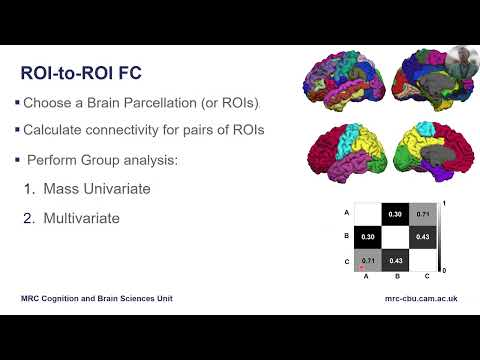

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('SqyNPbsgHNQ')

## **First we load some data**
### nilearn comes with datasets that have been made freely available and can be easily downloaded. Alternatively data can be downloaded through openneuro [fetch_openneuro_dataset](https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_openneuro_dataset.html) or with [datalad](https://www.datalad.org/) - see neuroimaging [example](https://dartbrains.org/content/Download_Data.html).

### We load a single subject first. The datafetcher is described [here](https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_development_fmri.html) and the data is cited [here](https://doi.org/10.1038/s41467-018-03399-2). This is an FMRI data while children and adults were watching a short movie. However, we would treat it as if participants were doing a resting-state scan for now.

In [8]:
development_dataset = datasets.fetch_development_fmri(age_group='child', # this data set has 122 children and 33 adults, we take one child here
                                                      n_subjects=1,
                                                      data_dir=save_dir,# number of subjects
                                                      reduce_confounds=True)# returns only 6 motion parameters csf,wm,FD and aCompcor


In [9]:
print(development_dataset.keys()) # a dictionary with names of different files
print('Path to newly downloaded file:\n %s\n' %development_dataset.func[0]) # data has been pre-processed so is already motion corrected and in MNI space
print('Path to newly downloaded file:\n %s\n' %development_dataset.confounds[0]) # confounds contains the motion parameters. The data was pre-processed using

dict_keys(['func', 'confounds', 'phenotypic', 'description'])
Path to newly downloaded file:
 /content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

Path to newly downloaded file:
 /content/development_fmri/development_fmri/sub-pixar001_task-pixar_desc-reducedConfounds_regressors.tsv



In [10]:
print(development_dataset['description'])

The movie watching based brain development dataset (fMRI)


Notes
-----
This functional MRI dataset is used for teaching how to use
machine learning to predict age from naturalistic stimuli (movie)
watching with Nilearn.

The dataset consists of 50 children (ages 3-13) and 33 young adults (ages
18-39). This dataset can be used to try to predict who are adults and
who are children.

The data is downsampled to 4mm resolution for convenience. The original
data is downloaded from OpenNeuro.

For full information about pre-processing steps on raw-fMRI data, have a look
at README at https://osf.io/wjtyq/

Full pre-processed data: https://osf.io/5hju4/files/

Raw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0

Content
-------
    :'func': functional MRI Nifti images (4D) per subject
    :'confounds': TSV file contain nuisance information per subject
    :'phenotypic': Phenotypic information for each subject such as age,
                   age group, gender,

### Here we load the confounds table and the image path and image

In [11]:
covariates = pd.read_csv(development_dataset.confounds[0], sep='\t')
covariates.head()

trans_x   trans_y   trans_z     rot_x         rot_y     rot_z  \
0  0.013422 -0.235811  0.033243 -0.000900 -9.976860e-24  0.000152   
1  0.030943 -0.238651  0.088048 -0.001747 -1.329770e-04  0.000154   
2  0.012758 -0.230284  0.097429 -0.001644 -0.000000e+00  0.000250   
3  0.010014 -0.213517  0.143186 -0.001455  9.294130e-05  0.000665   
4  0.059444 -0.259451  0.083982 -0.000378  3.686370e-04  0.001661   

   framewise_displacement  a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  \
0                0.000000      -0.044281      -0.258268       0.125255   
1                0.124271      -0.029137      -0.269449       0.144919   
2                0.052546      -0.016279      -0.266362       0.124585   
3                0.100117      -0.013480      -0.277391       0.114761   
4                0.272004      -0.004732      -0.257849       0.094339   

   a_comp_cor_03  a_comp_cor_04  a_comp_cor_05         csf  white_matter  
0      -0.000207       0.108816      -0.145942  818.550141    875.069943  
1      -0.037457       0.130096      -0.123405  815.643544    873.886244  
2      -0.029334       0.169594      -0.085291  820.769909    872.997093  
3      -0.024431       0.161647      -0.084730  816.815767    872.913170  
4      -0.006717       0.277185      -0.035150  818.287589    872.019839

In [12]:
labels = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','csf','white_matter']
covariates[labels]

trans_x   trans_y   trans_z     rot_x         rot_y     rot_z  \
0    0.013422 -0.235811  0.033243 -0.000900 -9.976860e-24  0.000152   
1    0.030943 -0.238651  0.088048 -0.001747 -1.329770e-04  0.000154   
2    0.012758 -0.230284  0.097429 -0.001644 -0.000000e+00  0.000250   
3    0.010014 -0.213517  0.143186 -0.001455  9.294130e-05  0.000665   
4    0.059444 -0.259451  0.083982 -0.000378  3.686370e-04  0.001661   
..        ...       ...       ...       ...           ...       ...   
163 -0.083838  0.080319 -0.161567  0.002857 -2.226720e-03 -0.000881   
164  0.079416  0.110220  0.332568 -0.000841 -8.429800e-04  0.000164   
165  0.047188  0.111766 -0.028702 -0.000116  6.980360e-04  0.000548   
166  0.032362 -0.020903 -0.030465  0.000168  1.920020e-04  0.000548   
167  0.087146  0.072233  0.050868 -0.000628  8.201730e-04  0.001479   

            csf  white_matter  
0    818.550141    875.069943  
1    815.643544    873.886244  
2    820.769909    872.997093  
3    816.815767    872.913170  
4    818.287589    872.019839  
..          ...           ...  
163  818.809920    866.674712  
164  810.969518    868.994620  
165  801.792841    867.731064  
166  807.183644    867.229653  
167  806.643344    866.786597  

[168 rows x 8 columns]

### Here we load the Functional Image for a single subject

In [13]:
image_path = development_dataset.func[0]
func_image = load_img(image_path)
# print(func_image.header)
# voxel dimmentions and TR in header; However often the TR is not correct in the header especially if value is 1 or 0
# here TR is 2 seconds

### Lets for now drop the aCompcor columns and compute 24 motion parameters from the 6 motion paramers

In [14]:
FD = covariates['framewise_displacement']
covariates.drop(list(covariates.filter(regex=r"a_comp_cor|framewise")),axis=1,inplace=True) # inplace is needed to actually change the dataframe without assigning it to a new dataframe
covariates.head()

# above we use regular expressions to find the columns containing the sting a_comp_cor or the string framewise
# This can be useful if we have multiple columns we want to select/drop. Below I show another way of achieving the same result
#labels = ['a_comp_cor_00','a_comp_cor_01',
#                 'a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05', 'framewise_displacement']
#covariates.drop(labels,axis=1,inplace=True)
#covariates.head()

trans_x   trans_y   trans_z     rot_x         rot_y     rot_z         csf  \
0  0.013422 -0.235811  0.033243 -0.000900 -9.976860e-24  0.000152  818.550141   
1  0.030943 -0.238651  0.088048 -0.001747 -1.329770e-04  0.000154  815.643544   
2  0.012758 -0.230284  0.097429 -0.001644 -0.000000e+00  0.000250  820.769909   
3  0.010014 -0.213517  0.143186 -0.001455  9.294130e-05  0.000665  816.815767   
4  0.059444 -0.259451  0.083982 -0.000378  3.686370e-04  0.001661  818.287589   

   white_matter  
0    875.069943  
1    873.886244  
2    872.997093  
3    872.913170  
4    872.019839

In [15]:
# first we compute the difference between each time-point and the previous time-point, we then also compute the squares of each column
# we rename the columns and then concatenate them
diff_temp = covariates.diff() # pandas have methods to compute difference between rows (or columns)
diff_temp.columns = 'diff_' + diff_temp.columns # alt: diff_temp.add_prefix('diff_') - but does not do it inplace
diff_sq = diff_temp.pow(2) # raise to power of 2
diff_sq.columns = ['sq_' + x for x in diff_sq.columns] # this is a list comprehention method that achieve the same as above renaming; list comprehension is a shorter way to write a for loop

cov_sq = covariates.pow(2)
cov_sq.columns = 'sq_' + cov_sq.columns


confounds_32 = pd.concat([covariates, diff_temp,cov_sq,diff_sq,FD],axis=1)
confounds_32 = (confounds_32 - confounds_32.mean())/(confounds_32.std()) # ignores NaNs by default
confounds_32.fillna(0,inplace=True) # changes NaN values to 0; Because of diff the first row will be NaN
confounds_32.head()

## plot confounds
# plt.figure(figsize=(20,20))
# ax = plt.gca() # get current axis
# ax.imshow(confounds_32,cmap='gray')


trans_x   trans_y   trans_z     rot_x     rot_y     rot_z       csf  \
0 -0.111050 -2.046948 -0.224668 -0.279399  0.075597 -0.041721  1.161748   
1  0.050107 -2.063051 -0.018570 -0.577816  0.015153 -0.040864  0.910323   
2 -0.117153 -2.015611  0.016707 -0.541421  0.075597 -0.002349  1.353762   
3 -0.142396 -1.920543  0.188782 -0.474803  0.117844  0.164120  1.011722   
4  0.312258 -2.180985 -0.033860 -0.095416  0.243161  0.563788  1.139037   

   white_matter  diff_trans_x  diff_trans_y  ...  sq_white_matter  \
0      1.727386      0.000000      0.000000  ...         1.719557   
1      1.553628      0.113466     -0.020546  ...         1.545139   
2      1.423107     -0.123740      0.028607  ...         1.414279   
3      1.410787     -0.021165      0.065448  ...         1.401934   
4      1.279653      0.325449     -0.209552  ...         1.270605   

   sq_diff_trans_x  sq_diff_trans_y  sq_diff_trans_z  sq_diff_rot_x  \
0         0.000000         0.000000         0.000000       0.000000   
1        -0.141818        -0.134629        -0.178920      -0.135440   
2        -0.141667        -0.134468        -0.185904      -0.142070   
3        -0.143729        -0.133917        -0.181099      -0.141835   
4        -0.128180        -0.129152        -0.177719      -0.131292   

   sq_diff_rot_y  sq_diff_rot_z  sq_diff_csf  sq_diff_white_matter  \
0       0.000000       0.000000     0.000000              0.000000   
1      -0.148455      -0.120622    -0.271005             -0.195728   
2      -0.148455      -0.120537    -0.183614             -0.206900   
3      -0.148683      -0.119046    -0.235782             -0.221237   
4      -0.146986      -0.111539    -0.301794             -0.206763   

   framewise_displacement  
0               -0.472607  
1               -0.320822  
2               -0.408427  
3               -0.350324  
4               -0.140380  

[5 rows x 33 columns]

### Let is create a function to clean up the confound files

In [16]:
def make_motion_covariates(mc):
  # this function takes a path to a confounds file from fmriprep, extracts the 6 motion parameters, CSF, WM and FD
  # and computes the extended 32 motion parameters
  if type(mc) == str:
    covariates = pd.read_csv(mc, sep='\t')
    FD = covariates['framewise_displacement']
    labels = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','csf','white_matter']
    covariates = covariates[labels]
    diff_temp = covariates.diff()
    diff_temp.columns = 'diff_' + diff_temp.columns
    diff_sq = diff_temp.pow(2)
    diff_sq.columns = ['sq_' + x for x in diff_sq.columns]
    cov_sq = covariates.pow(2)
    cov_sq.columns = 'sq_' + cov_sq.columns
    confounds_32 = pd.concat([covariates, diff_temp,cov_sq,diff_sq,FD],axis=1)
    confounds_32 = (confounds_32 - confounds_32.mean())/(confounds_32.std())
    confounds_32.fillna(0,inplace=True)
  elif type(mc) == list:
    confounds_32 = []
    for cov in mc:
      covariates = pd.read_csv(cov, sep='\t')
      FD = covariates['framewise_displacement']
      labels = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','csf','white_matter']
      covariates = covariates[labels]
      diff_temp = covariates.diff()
      diff_temp.columns = 'diff_' + diff_temp.columns
      diff_sq = diff_temp.pow(2)
      diff_sq.columns = ['sq_' + x for x in diff_sq.columns]
      cov_sq = covariates.pow(2)
      cov_sq.columns = 'sq_' + cov_sq.columns
      confounds_frame = pd.concat([covariates, diff_temp,cov_sq,diff_sq,FD],axis=1)
      confounds_frame = (confounds_frame - confounds_frame.mean())/(confounds_frame.std())
      confounds_frame.fillna(0,inplace=True)
      confounds_32.append(confounds_frame)

  return confounds_32


#### <span style='color:orange'>Simple image manipulaitons</span>
## <span style='color:orange'> You can skip this section as it has been covered previously, however if you want a refresher you can have a look at the code below, we calculate the global signal that can be used later on as an additional confound  </span>


Func image shape (x,y,z,TR): (50, 59, 50, 168)
shape of TR 1: (50, 59, 50)
Before masking, our data has shape (50, 59, 50, 168) ...
... and afterwards our data has shape (168, 30174) and is a ndarray
Shape of global signal (168,)


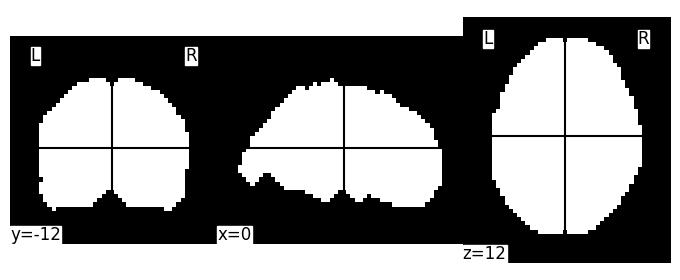

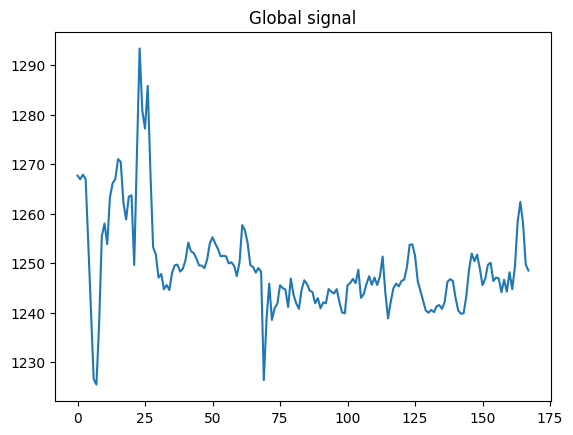

In [17]:
# @title Image manipulation, e.g., creating a brain mask and calculating global signal
from nilearn.image import load_img, index_img, mean_img
from nilearn import image

mean_fun = mean_img(func_image)

print('Func image shape (x,y,z,TR):', func_image.shape) # x,y,z,TRs
first_img = index_img(image_path,0) # how to grab only certain TR
print('shape of TR 1:', first_img.shape)
#plotting.plot_epi(image_path)

#grab_first_5 = index_img(image_path, slice(0,5)) # How to grab several TRs
#mean_first_5 = mean_img(grab_first_5)

#plotting.plot_epi(mean_img(image_path),title='Mean Image',cmap='gray')

#plotting.view_img(image.mean_img(image_path),threshold=0,cmap='gray') # interactive view of mean EPI


# now lets plot a selection of TRs but also mask them. a EPI mask is estimating where is there signal in the image.
# computing a brain mask
masked_img = masking.compute_epi_mask(mean_fun)
masked_img.to_filename('EPI_Mask.nii')
plotting.plot_img(masked_img,cmap='gray')
#plotting.plot_roi(masked_img,bg_img=mean_fun,cmap='viridis')

## digression apart from computing mean EPI you can also extract additional confounds e.g., the time series of the
# voxels with highest variance
# Noisy_data = image.high_variance_confounds(func_image,mask_img=masked_img); see documentation if interested
##

print("Before masking, our data has shape %s ..." % (func_image.shape,))
func_masked = masking.apply_mask(func_image, masked_img) # we extract signal from whole brain mask
print("... and afterwards our data has shape %s and is a %s" % (func_masked.shape, type(func_masked).__name__))
global_signal = np.mean(func_masked,axis=1)
print("Shape of global signal",global_signal.shape)

#func_unmasked = masking.unmask(func_masked, masked_img)
#print("func_unmasked is a %s and has shape %s" % (type(func_unmasked).__name__, func_unmasked.shape))


# grab functional volumes 0, 100 and 167 and multiply them by the EPI mask
# math_img module allows you to do operations on the 4D images.
selected_volumes = image.index_img(func_image,[0,100,167])
selected_volumes_mask = image.math_img('img1*img2[:,:,:,np.newaxis]', img1=selected_volumes, img2=masked_img)
#for img in image.iter_img(selected_volumes_mask):
#   plotting.plot_stat_map(img,threshold=1,bg_img=None,black_bg=True)


plt.figure()
plt.plot(global_signal)
ax= plt.gca()
ax.set_title('Global signal')
plt.show()


Shape 2-D image (30174,)


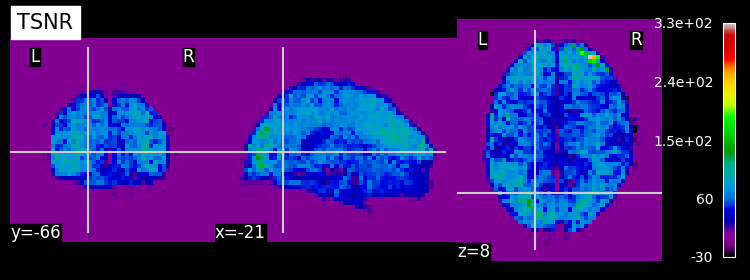

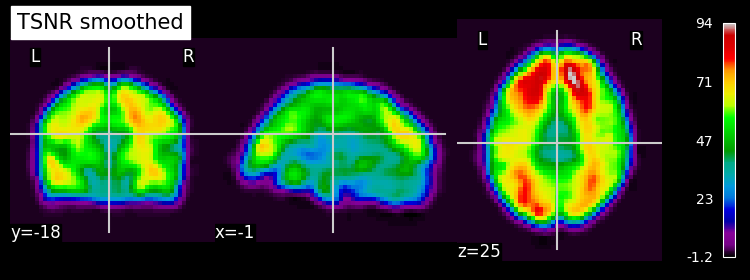

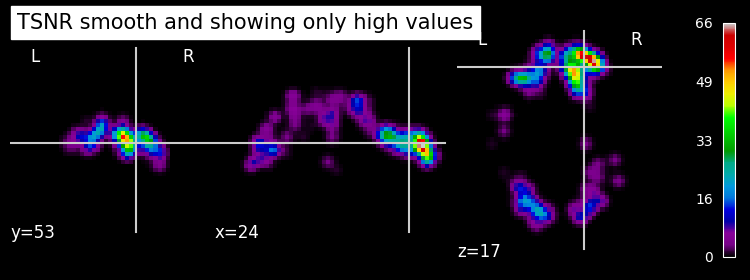

In [18]:
# @title Compute SNR over image
# compute SNR image on 4D image unmasked
tsnr_func = image.math_img('np.mean(img,axis=3)/np.std(img,axis=3)',img=func_image)
plotting.plot_epi(tsnr_func,colorbar=True, title='TSNR')

tsnr_func_smm = image.smooth_img(tsnr_func,fwhm=10)
plotting.plot_epi(tsnr_func_smm, colorbar=True,title='TSNR smoothed')

tsnr_np = np.mean(func_masked,axis=0)/np.std(func_masked,axis=0);
print('Shape 2-D image', tsnr_np.shape)

tsnr_np[tsnr_np<100] = np.nan

tsnr_remove_valuebelow_100 = masking.unmask(tsnr_np, masked_img)
tsnr_remove_valuebelow_100smm = image.smooth_img(tsnr_remove_valuebelow_100, fwhm=10)
plotting.plot_epi(tsnr_remove_valuebelow_100smm,colorbar=True,title='TSNR smooth and showing only high values')

<br><br><br>
#### A useful way to visualise the data is with a carpet plot introduced in [1](https://doi.org/10.1016/j.neuroimage.2016.08.009)
#### Note that this visualization is very helpful for understanding NiftiMaskers and how to represent 4-D fMRI data as matrix on which we can easily perform mathematical operations
---


see also [2](https://github.com/niksirbi/pcarpet) for some applications of the plot.
[3](https://doi.org/10.1016/j.neuroimage.2020.116614) for a recent discussion on global signal regression


Dataset created in /content/icbm152_2009



 ...done. (3 seconds, 0 min)
Extracting data from /content/icbm152_2009/e05b733c275cab0eec856067143c9dc9/download..... done.


Coercing atlas_values to <class 'int'>


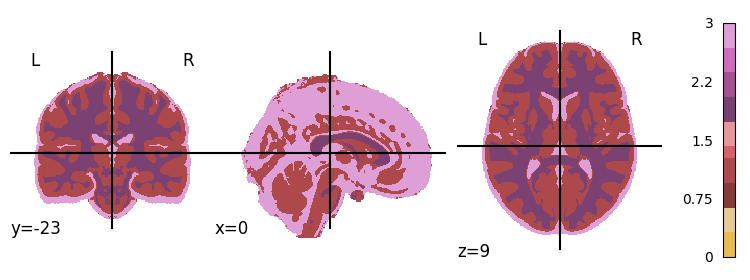

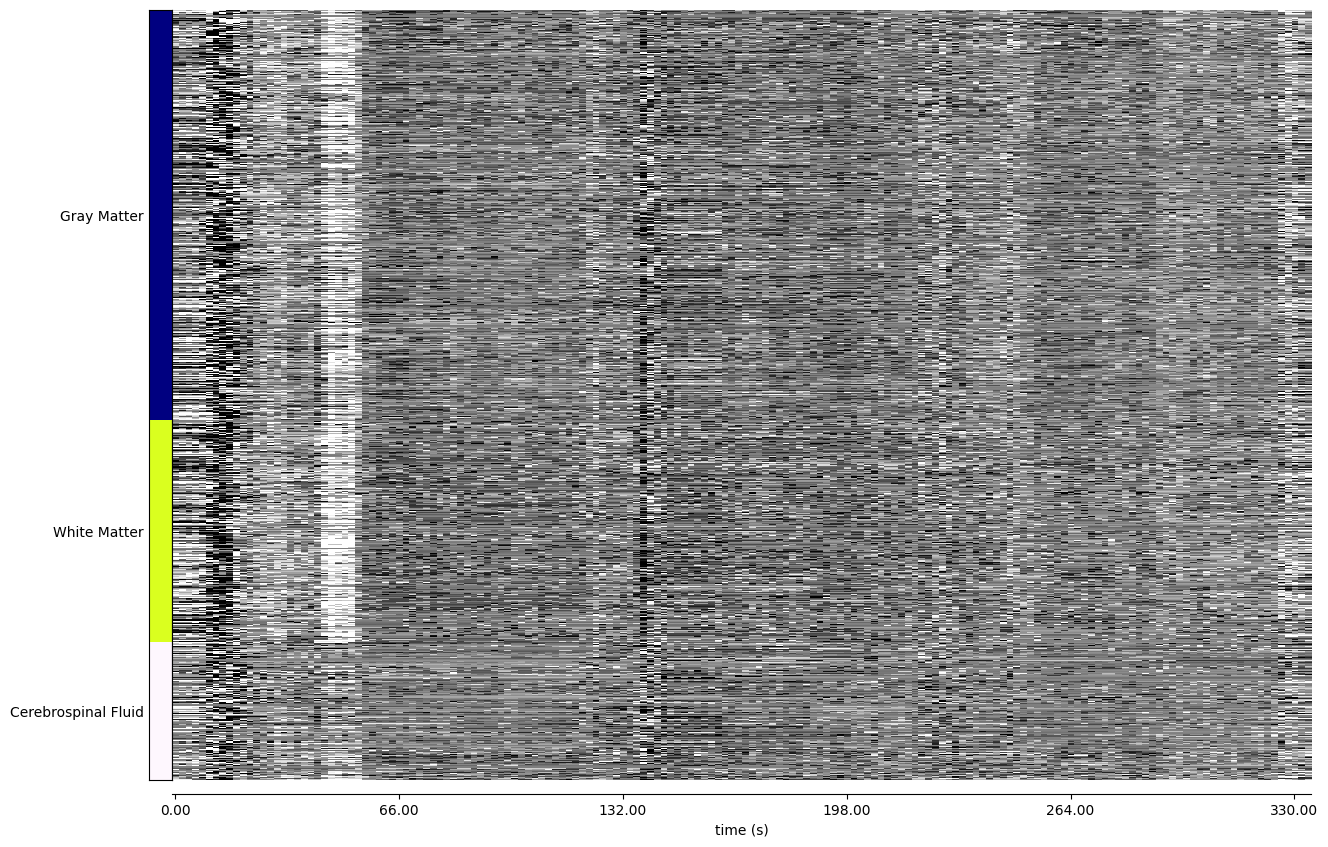

In [19]:
#display = plotting.plot_carpet(image_path, masked_img, t_r = 2) # does not show labels of gray and white matter
# grab atlas to have tissue probability map

atlas=datasets.fetch_icbm152_2009(data_dir=save_dir) # this downloads an atlas
atlas_img = image.concat_imgs((atlas["gm"], atlas["wm"], atlas["csf"])) # we select the Gray matter, White matter and CSF segmented images
map_labels={"Gray Matter": 1, "White Matter": 2, "Cerebrospinal Fluid": 3} # We assign them labels

atlas_data = atlas_img.get_fdata() # This is the raw image data
discrete_version = np.argmax(atlas_data, axis = 3) + 1 # we find the index of maxium value across gm,wm and csf for each voxel
discrete_version[np.max(atlas_data, axis = 3) == 0] = 0
discrete_atlas_img = image.new_img_like(atlas_img,discrete_version) # make an image

plotting.plot_stat_map(discrete_atlas_img,cmap='tab20b')

fig, ax = plt.subplots(figsize=(15, 10))

display = plotting.plot_carpet(
    image_path,
    discrete_atlas_img,
    t_r=2,
    mask_labels=map_labels,
    axes=ax,
    cmap="gray",
)

fig.show()


## The NiftiMasker

### It transforms the data from 4D to a 2D matrix (time by voxels) this makes it easy to work with various functions

### This can be used to compute brain mask but also can be used to temporally pre-process your data and extract data from ROIs.

### Importantly one can transform the 2D matrix back into 4D image
<br><br>
<img src="https://b01.eventmemory.org/APPCA/NiftiMasker.png" width=900 height=600 />


<br><br><br><br><br>
# 1. We first show how to perform seed to whole brain analysis

In [20]:
# development_dataset = datasets.fetch_development_fmri(age_group='child', # this data set has 122 children and 33 adults, we take one child here
#                                                       n_subjects=1, # number of subjects
#                                                       reduce_confounds=True, data_dir = save_data_dir)
# image_path = development_dataset.func[0]
# func_image = load_img(image_path)

In [21]:
pcc_coords = [(0,-52,18)] # x,y,z coordinates

seed_masker = NiftiSpheresMasker(pcc_coords, radius=8,
                                 detrend=True,
                                 standardize='zscore',
                                 high_pass=0.008,
                                 t_r=2)

seed_time_series = seed_masker.fit_transform(func_image, confounds = confounds_32)

brain_masker = NiftiMasker(smoothing_fwhm=6,
                          detrend=True,
                          standardize='zscore',
                          high_pass=0.008,
                          t_r=2)

brain_time_series = brain_masker.fit_transform(func_image,confounds=confounds_32)

print(f"Seed time series shape: ({seed_time_series.shape})")
print(f"Brain time series shape: ({brain_time_series.shape})")

Seed time series shape: ((168, 1))
Brain time series shape: ((168, 39738))


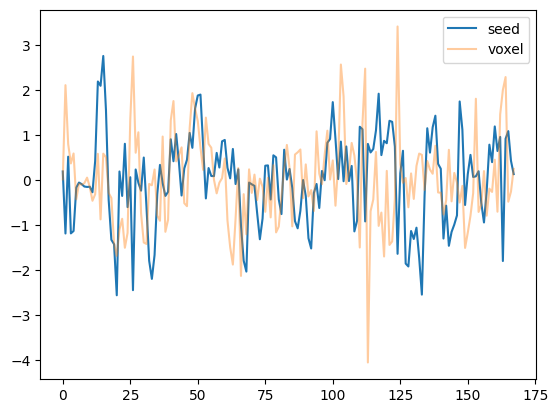

In [22]:
plt.plot(seed_time_series,label='seed')
plt.plot(brain_time_series[:,2000],alpha=0.4,label='voxel')
plt.legend()

In [23]:
seed_to_voxel_correlations = np.dot(brain_time_series.T,seed_time_series)/seed_time_series.shape[0]

print(
    "Seed-to-voxel correlation shape: (%s, %s)"
    % seed_to_voxel_correlations.shape
)
print(
    "Seed-to-voxel correlation: min = %.3f; max = %.3f"
    % (seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())
)

Seed-to-voxel correlation shape: (39738, 1)
Seed-to-voxel correlation: min = -0.598; max = 0.884


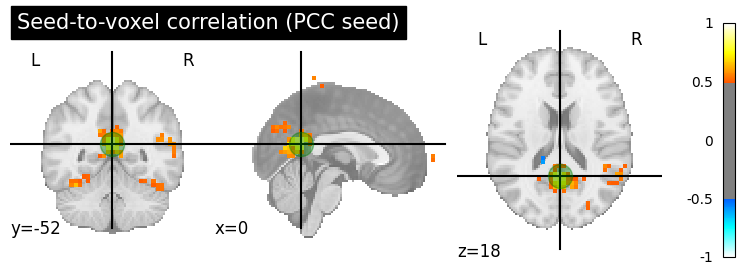

In [24]:
seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T
)
display = plotting.plot_stat_map(
    seed_to_voxel_correlations_img,
    threshold=0.5,
    vmax=1,
    cut_coords=pcc_coords[0],
    title="Seed-to-voxel correlation (PCC seed)",
)
display.add_markers(
    marker_coords=pcc_coords, marker_color="g", marker_size=300,alpha=0.4
)
# At last, we save the plot as pdf.
display.savefig("pcc_seed_correlation.pdf")

#### Before continuing with the seed to whole brain analysis we show that one can comput also the seed to seed connectivity matrix

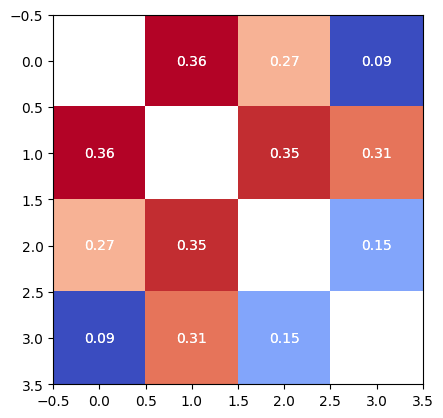

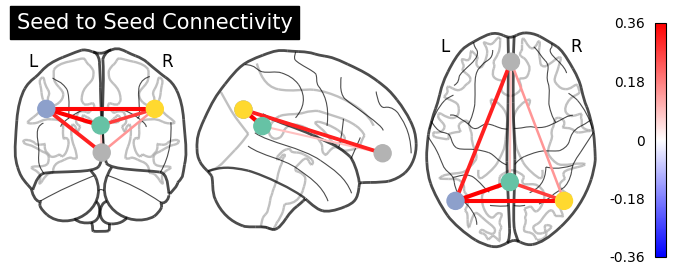

In [25]:
sphere_center = [(  0, -52, 18),
                 (-46, -68, 32),
                 ( 46, -68, 32),
                 (  1,  50, -5)]

Spheres_masker = NiftiSpheresMasker(sphere_center, radius=8, detrend=True,
                            standardize=True, high_pass=0.008,
                            t_r=2.0, verbose=0, memory="nilearn_cache", memory_level=2)
sphere_time_series = Spheres_masker.fit_transform(func_image,confounds=confounds_32)

connectivity_measure_partial = ConnectivityMeasure(kind='correlation')
partial_correlation_matrix = connectivity_measure_partial.fit_transform([sphere_time_series])[0]
np.fill_diagonal(partial_correlation_matrix,np.nan)
## Plotting the partical correlation matrix
fig, ax = plt.subplots()
plt.imshow(partial_correlation_matrix, cmap='coolwarm')
for (j,i),label in np.ndenumerate(partial_correlation_matrix):
    ax.text(i, j, round(label, 2), ha='center', va='center', color='w')
    ax.text(i, j, round(label, 2), ha='center', va='center', color='w')

plotting.plot_connectome(partial_correlation_matrix, sphere_center,
            display_mode='ortho', colorbar=True,  node_size=150,
            title="Seed to Seed Connectivity")


# Now we return to the multi subject data set to show how to perform the seed to whole brain connectivity analysis

1. First we have to extract the seed time course from each subject
2. We have to extract the voxel time courses from the masked fMRI image from each subject
3. Then we can compute the correlation between the seed and every voxel in the brain
4. Then we save the seed to whole brain Nifti images that can be submitted to second level analysis similar to what you learned before.
5. We show how to compare the connectivity between the seed and the whole brain between children and adults.

In [26]:
Nsub=40
seed_data_set = datasets.fetch_development_fmri(n_subjects=Nsub,data_dir=save_dir,verbose=0)

seed_counfounds = make_motion_covariates(seed_data_set.confounds)

In [27]:
pcc_coords = [(0,-52,18)] # x,y,z coordinates for a seed region

seed_masker = NiftiSpheresMasker(pcc_coords, radius=8,
                                 detrend=True,
                                 standardize='zscore',
                                 high_pass=0.008,
                                 t_r=2)

brain_masker = NiftiMasker(smoothing_fwhm=6,
                          detrend=True,
                          standardize='zscore',
                          high_pass=0.008,
                           t_r=2) # Nifti masker uses signal.clean to also run temporal filtering of the data

# we initialize emtpy lists
group_list = []
list_filenames = []

# with zip we can include the functional files the confounds and the phenotypic variables that stores the person's age
# and iterate over it
# an alternative would be to use enumerate and index each of these variables
for func_file, confound_file, phenotypic in zip(
    seed_data_set.func,
    seed_counfounds,
    seed_data_set.phenotypic,
):

    # Here I use regular expression to grab the subject ID from the functional files so
    # I can save the result with the correct subject ID
    result = re.search('sub-(.*)_task',func_file) # This searchers for everything in the string func_file that is between the strings sub- and _task
    subj = result.group(1)

    if phenotypic["Child_Adult"] == "child":
        group = 'C'
        group_list.append(1) # we append 1 indicator if the subject is a child
    elif phenotypic["Child_Adult"] == 'adult':
        group = 'A'
        group_list.append(0) # we append 0 indicator if the subject is a adult

    seed_voxel_filename = 'pcc_seed_sub_%s_corr_z_G_%s.nii.gz' %(subj, group) # we set the result file name
    list_filenames.append(seed_voxel_filename) # we accumulate over the for loop the file names

    # Here for each subject we extract seed and voxel time series, correlate them and perform Fisher Z transformation
    seed_time_series = seed_masker.fit_transform(func_file, confounds=confound_file)
    brain_time_series = brain_masker.fit_transform(func_file,confounds=confound_file)

    seed_to_voxel_correlations = np.dot(brain_time_series.T,seed_time_series)/seed_time_series.shape[0]

    seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)

    # The brain_masker.inverse_transform method is very helpful as we can convert the numpy array back into a nifti image
    seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
        seed_to_voxel_correlations_fisher_z.T
    )
    seed_to_voxel_correlations_fisher_z_img.to_filename(
        seed_voxel_filename
    ) # here we save the nifti image

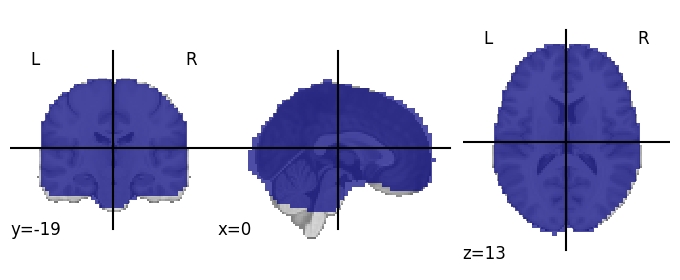

In [28]:
common_epi_mask = nilearn.masking.compute_multi_epi_mask(seed_data_set.func,
                                       lower_cutoff=0.2, upper_cutoff=0.85,
                                       connected=True, opening=2, threshold=0.5,
                                       target_affine=None, target_shape=None,
                                       exclude_zeros=False, n_jobs=1, memory=None, verbose=0)

plotting.plot_roi(common_epi_mask) #

In [29]:
temp_Series = pd.Series(group_list) # we have a list of 0s and 1s
dummy_coded = pd.get_dummies(temp_Series,prefix='group') # with pandas we can create dummy indicators that are useful for the design matrix
dummy_coded.rename(columns={'group_0':'adult','group_1':'child'},inplace=True) # we give appropriate names to the columns
dummy_coded.head(12) # we show the first 12 values of the Panda Dataframe

adult  child
0       1      0
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       1      0
7       1      0
8       1      0
9       0      1
10      0      1
11      0      1

### Design Matrix or X is what we use in GLMs to define the regressors or tests we are interested in doing. You can see that the above design matrix corresponds to a two sample t-test. Note there are multiple ways one can define a design matrix to perform effectively the same hypothesis test and they affect the interpretation of the beta values and what contrast is needed. see this [videos](https://www.youtube.com/playlist?list=PLB2iAtgpI4YHUJcyXnaoR3sWKSdhYDtjD) for more detailed examples, specifically Day 10 video.

![Image](https://dartbrains.org/_images/DesignMatrices.png)
[see here](https://dartbrains.org/content/Group_Analysis.html#group-statistics-using-design-matrices) for some worked out examples of different designs

In [30]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(mask_img=common_epi_mask)
second_level_model = second_level_model.fit(list_filenames, design_matrix =  dummy_coded) # Here we have to specify the input the fmri images and the design matrix

### To define a contrast we can either use the column name in the design matrix or provide a numpy array

In [31]:
t_map_child = second_level_model.compute_contrast('child',output_type='stat') # z_score for z_map
t_map_child_vs_adult = second_level_model.compute_contrast('child-adult',output_type='stat') # alternatively
#t_map_child_vs_adult = second_level_model.compute_contrast([-1, 1],output_type='stat')

highest t-stat:  6.778450308828943


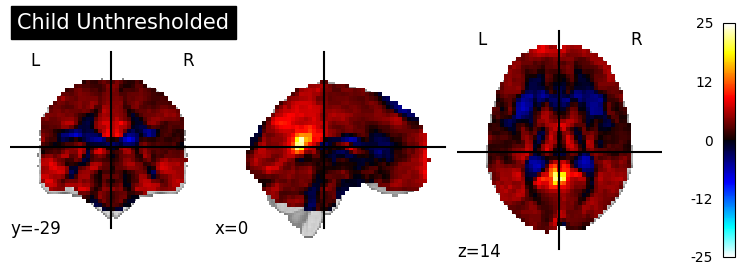

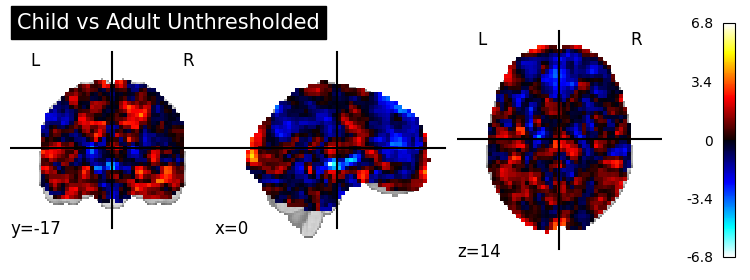

In [32]:
plotting.plot_stat_map(t_map_child,title='Child Unthresholded')
plotting.plot_stat_map(t_map_child_vs_adult,title='Child vs Adult Unthresholded')
print('highest t-stat: ',(t_map_child_vs_adult.get_fdata()).max())

In [33]:
from nilearn.reporting import make_glm_report
report = make_glm_report(model = second_level_model,
                        contrasts = ["child","child-adult"])

report

# report.save_as_html('PCC_seed_report.html')
# report.open_in_browser()

### Note Nilearn does not perform the typical cluster level correction. Below we show voxel-wise FWE correction which is very strict.

Uncorrected p<.05 threshold: 1.960


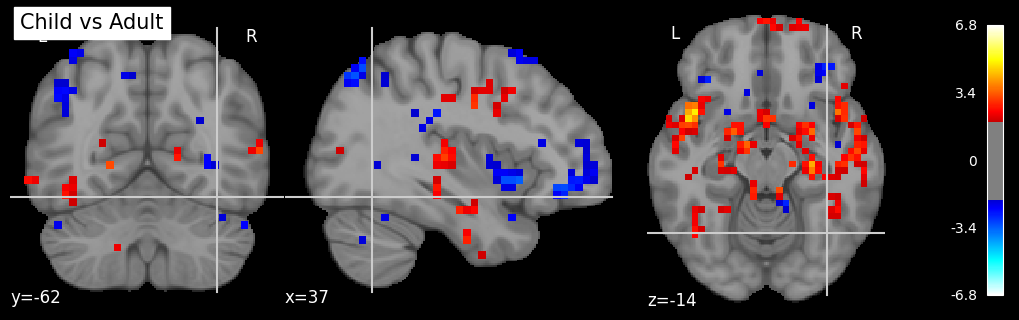

FWE p<.05 threshold: 5.513


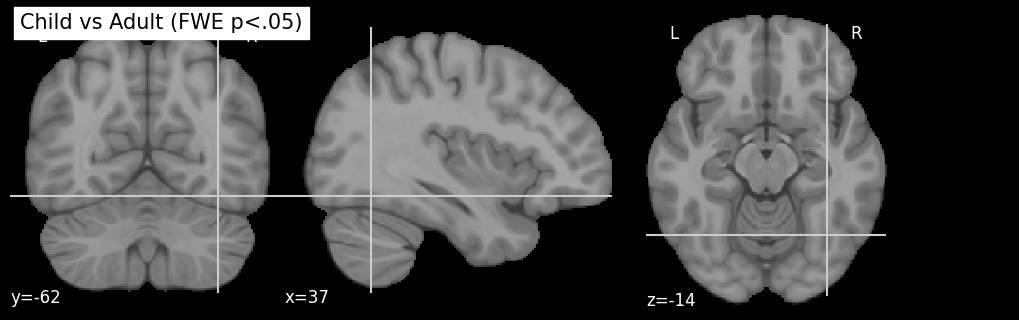

In [34]:
from nilearn.glm.thresholding import threshold_stats_img

cluster_map, threshold = threshold_stats_img(t_map_child_vs_adult,
                                             alpha=0.05,
                                             height_control='fpr',
                                            two_sided=True)


from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('Uncorrected p<.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    cluster_map,
    threshold = threshold,
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = 'Child vs Adult')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()




cluster_map, threshold = threshold_stats_img(
    t_map_child_vs_adult, alpha=.001,
    height_control='bonferroni',
    two_sided=True)

print('FWE p<.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    cluster_map,
    threshold = threshold,
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = 'Child vs Adult' + ' (FWE p<.05)')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

### In nilearn you can do cluster level inference following the method described [here](https://doi.org/10.1016/j.neuroimage.2018.07.060)

In [35]:
from scipy.stats import norm
p_val = 0.001 # height threshold
z_uncorrected = norm.isf(p_val)
print(z_uncorrected)

z_map_child_vs_adult = second_level_model.compute_contrast('child-adult',output_type='z_score') # alternatively


from nilearn.glm import cluster_level_inference
proportion_true_discoveries_img = cluster_level_inference(z_map_child_vs_adult,alpha=0.05)



3.090232306167813


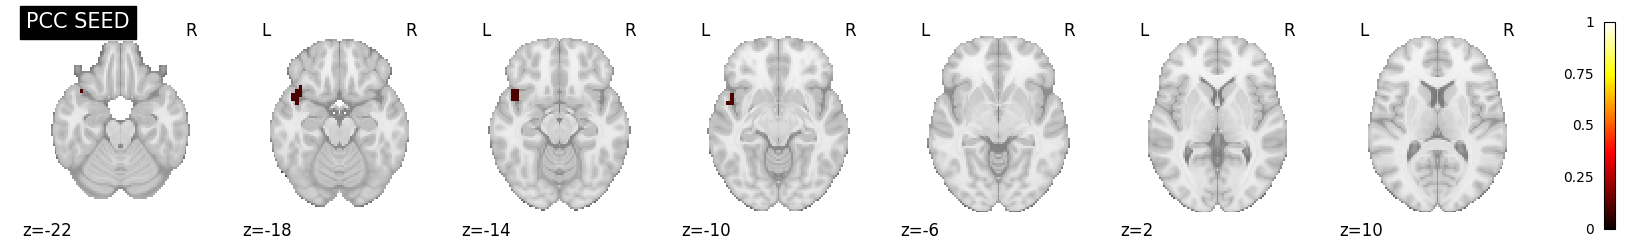

In [36]:
plotting.plot_stat_map(
    proportion_true_discoveries_img,
    threshold=0.0,
    display_mode="z",
    vmax=1,
    colorbar=True,
    title="PCC SEED",
)

### Although we cannot perform parametric cluster correction that relies on random field theory. We can perform multiple correction using permutation testing. This can achieve cluster size correction or perform the TFCE method that aims to combine information from both the height and extend of the cluster when determining whether a cluster is significant.


In [37]:
from nilearn.glm.second_level import non_parametric_inference

nperm = 500 # ideally more than 5000

out_dict = non_parametric_inference(list_filenames[9:], design_matrix=pd.DataFrame([1]*31,columns=['intercept']),
                                   model_intercept=False,
                                   n_perm=nperm,# ideally more than 5000
                                   two_sided_test=False,
                                   n_jobs=2,threshold=0.001,
                                   tfce=True)
print(out_dict.keys())

dict_keys(['t', 'logp_max_t', 'tfce', 'logp_max_tfce', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


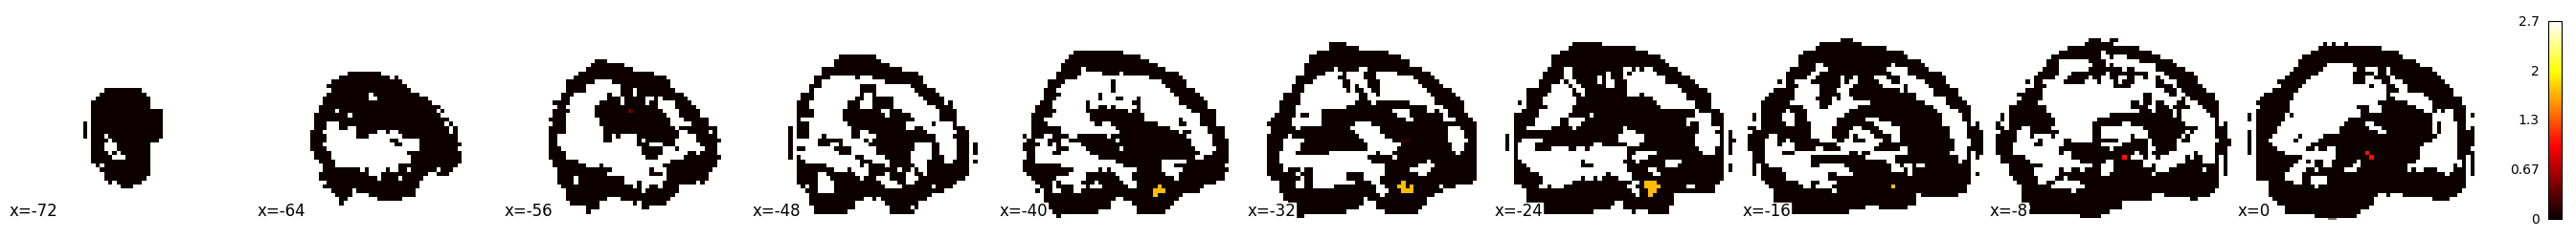

In [38]:
plotting.plot_stat_map(out_dict['logp_max_size'],cut_coords=10,display_mode='x')

The non_parametric_inference returns the negative log10 of the p_values.
So above we are plotting negative log p-values but not thresholding them to be below alpha of 0.05,
to do this we have to set the threshold at -np.log10(0.05)

Threshold for p < 0.05 1.3010299956639813


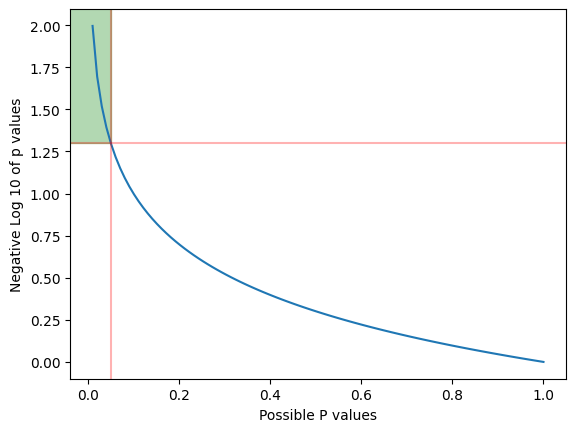

In [39]:
plt.plot(np.linspace(1,0,100), -np.log10(np.linspace(1,0,100)))
ax = plt.gca()
plt.axvline(0.05,color='red',alpha=0.3)
plt.axhline(-np.log10(0.05),color='red',alpha=0.3)
ax.set_xlabel('Possible P values')
ax.set_ylabel('Negative Log 10 of p values')
from matplotlib.patches import Rectangle

rec=Rectangle((-0.05,-np.log10(0.05)),0.1,0.8,color='green',alpha=0.3)
ax.add_patch(rec)

print('Threshold for p < 0.05', -np.log10(0.05))

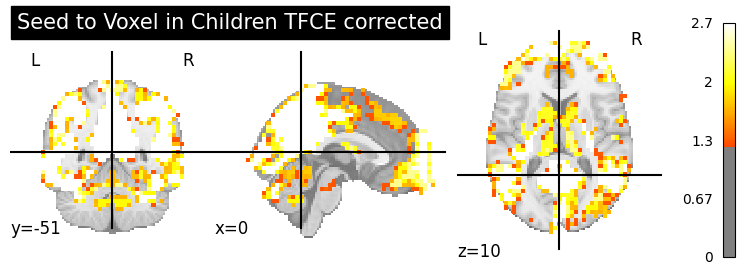

In [40]:
plotting.plot_stat_map(out_dict['logp_max_tfce'],threshold=-np.log10(0.05),title='Seed to Voxel in Children TFCE corrected')

2.6989700043360187


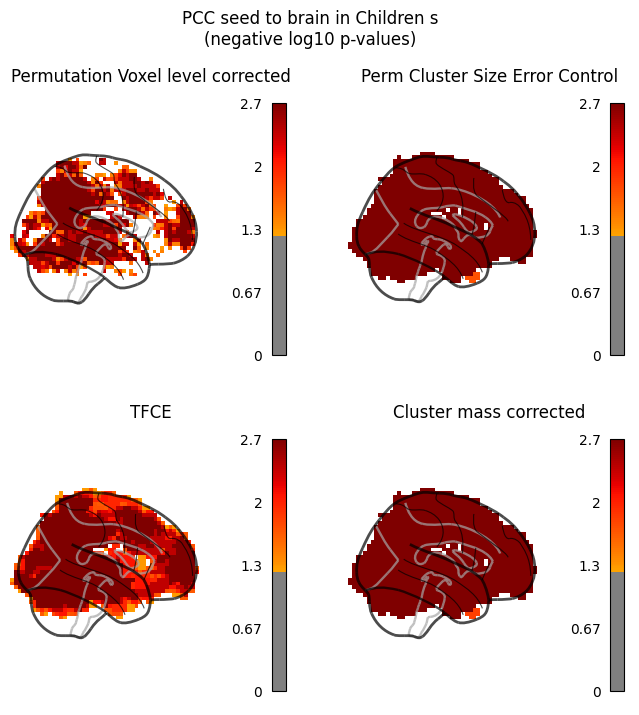

In [41]:
IMAGES = [out_dict['logp_max_t'],out_dict['logp_max_size'],out_dict['logp_max_tfce'], out_dict['logp_max_mass']]
TITLES = ['Permutation Voxel level corrected','Perm Cluster Size Error Control','TFCE','Cluster mass corrected']

import itertools
threshold= -np.log10(0.05)
vmax = -np.log10(1 / nperm) # if we perform 500 permutations we cannot have a p-value that is lower than 1/500
print(vmax)
cut_coords = 20
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        vmax=vmax,
        display_mode="x",
        plot_abs=False,
        cut_coords=cut_coords,
        threshold=threshold,
        figure=fig,
        axes=ax,cmap='jet'
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("PCC seed to brain in Children s\n(negative log10 p-values)")
plt.show()

#### Alternatively you can use fsl's [randomize](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide)

<br>
fslmerge -t PCC_4D.nii $(imglob pcc*gz)
<br>
Glm # set design and contrasts with Gui
<br>
randomise -i PCC_4D.nii.gz -o FSLTwo_sample -d fsl_design.mat -t fsl_design.con -m EPI_Mask.nii -T -n 5000
<br>
 fsl_design.mat is the design matrix like dummy_coded;
 fsl_design.con is a list of contrasts e.g., for child and child - adult;
 T  is for TFCE;
 n is number of permutations;

For theory of cluster correction you can see this video [1](https://www.youtube.com/watch?v=Ra2sWtZ-i08&ab_channel=mumfordbrainstats) and about TFCE this [one](https://www.youtube.com/watch?v=q7cWw8WC0Ws&t=568s&ab_channel=mumfordbrainstats)

# 2. We show how to extract signal from an Atlas and compute ROIxROI connectivity Matrix

## To choose ROIs we may use an Atlas or Parcellation
## Parcellations can be anatomically, or functionally defined.
## Two types of atlases can be fetched from nilearn automatically:
> 1. labeled images 3D with each ROI being different number; No overlap across ROIs
> 2. probibalistic 4D image which each ROI in the 4th dimension and there is overlap

### Here we show a labeled or 3D nifti image that holds each region as a different number. There is no overlap across ROIs


Dataset created in /content/fsl



 ...done. (1 seconds, 0 min)
Extracting data from /content/fsl/c4d84bbdf5c3325f23e304cdea1e9706/HarvardOxford.tgz..... done.


Shape of Atlas - (91, 109, 91)
Keys in Dictionary: dict_keys(['filename', 'maps', 'labels'])


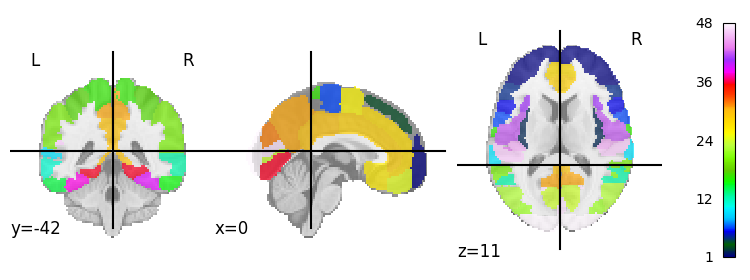

In [42]:
dataset_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm",data_dir=save_dir)
atlas_filename = dataset_ho.maps
plotting.plot_roi(atlas_filename,colorbar=True)
temp_atlas = image.load_img(atlas_filename)
print(f'Shape of Atlas - {temp_atlas.shape}') # here we have one 3D image and each ROI is different number
print('Keys in Dictionary:',dataset_ho.keys())

In [43]:
temp = pd.DataFrame(dataset_ho)
temp['labels'].head(5)

0                Background
1              Frontal Pole
2            Insular Cortex
3    Superior Frontal Gyrus
4      Middle Frontal Gyrus
Name: labels, dtype: object

 ### Here we load a probibalistic atlas that holds each ROI as a separate volume in a 4D image. ROIs can overlap. This is similar to how we used the ICA components as ROIs

Shape probabilistic atlas (91, 109, 91, 48)


0      Background
1    Frontal Pole
Name: labels, dtype: object

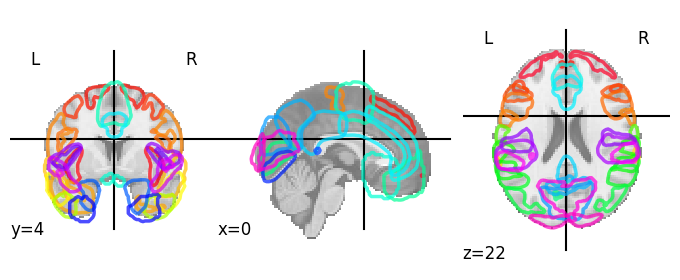

In [44]:
ho_prob_atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm',data_dir=save_dir)
prob_filename = ho_prob_atlas['maps']
plotting.plot_prob_atlas(prob_filename) # Note here we don't use plot_roi but plot_prob_atlas
temp_prob = image.load_img(prob_filename)
print(f'Shape probabilistic atlas {temp_prob.shape}')
temp_Series = pd.DataFrame(ho_prob_atlas)
temp_Series['labels'].head(2)

## There are multiple atlases and possible parcellations. This is still an ongoing research topic and it is unlikely that there is one parcellation that fits all questions. Below I include some important references on the topic. It is likely that there is not a single parcellation that works best for all cases. Your choice of an atlas will be guided on what you want to do later on

## Check out [Neuroparc](https://github.com/neurodata/neuroparc) and the paper Lawrence et al., [(2021)](https://doi.org/10.1038/s41597-021-00849-3)

## You can create anatomical or functional atlases see Moghimi et al., [(2021)](https://arxiv.org/ftp/arxiv/papers/2107/2107.03475.pdf) for a recent review, see also Passingham et al.,  [(2002)](https://doi.org/10.1038/nrn893)

## The numer of ROIs to be used is an ongoing research question using higher number of ROIs seems to better capture the underlying functional connectivity present at the voxel scale see [this](https://doi.org/10.1002/hbm.21333). The functional parcellation could also differ based on the task has been previously shown Geerligs et al., [(2015)](https://doi.org/10.1523/JNEUROSCI.1324-15.2015) see also [this](https://doi.org/10.1016/j.neuroimage.2019.116366) and [this](https://doi.org/10.1038/nn.4135) and possibly [this](https://doi.org/10.1371/journal.pone.0007200); and [this](https://doi.org/10.1016/j.neuroimage.2017.08.068)

# <span style='color:blue'> Extracting signal from probalistic atlas - NiftiMapsMasker </span>



Dataset created in /content/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /content/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


Shape probabilistic atlas (40, 48, 35, 39)


0    L Aud
1    R Aud
Name: labels, dtype: object

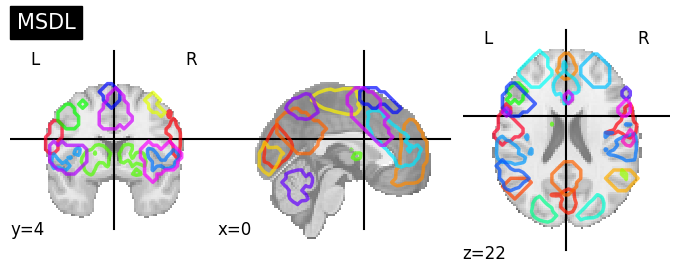

In [45]:
atlas = datasets.fetch_atlas_msdl(data_dir=save_dir)
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
plotting.plot_prob_atlas(atlas_filename,title='MSDL')
temp_prob = image.load_img(atlas_filename)
print(f'Shape probabilistic atlas {temp_prob.shape}')
# Loading atlas data stored in 'labels'
labels = atlas["labels"]
temp_Series = pd.DataFrame(atlas)
temp_Series['labels'].head(2)

#print(
#    "First subject resting-state nifti image (4D) is located "
#    f"at: {image_path}"
#)

In [46]:
masker = NiftiMapsMasker(maps_img=atlas_filename,verbose=1) # we can create a masker that is not applied to the data
#masker.fit(image_path) # pre-computes which is not useful here
time_series = masker.fit_transform(image_path) # computes masker and transforms data into 2-D matrix
print(time_series.shape)

[NiftiMapsMasker.wrapped] loading regions from /content/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[NiftiMapsMasker.transform_single_imgs] Loading data from /content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
(168, 39)


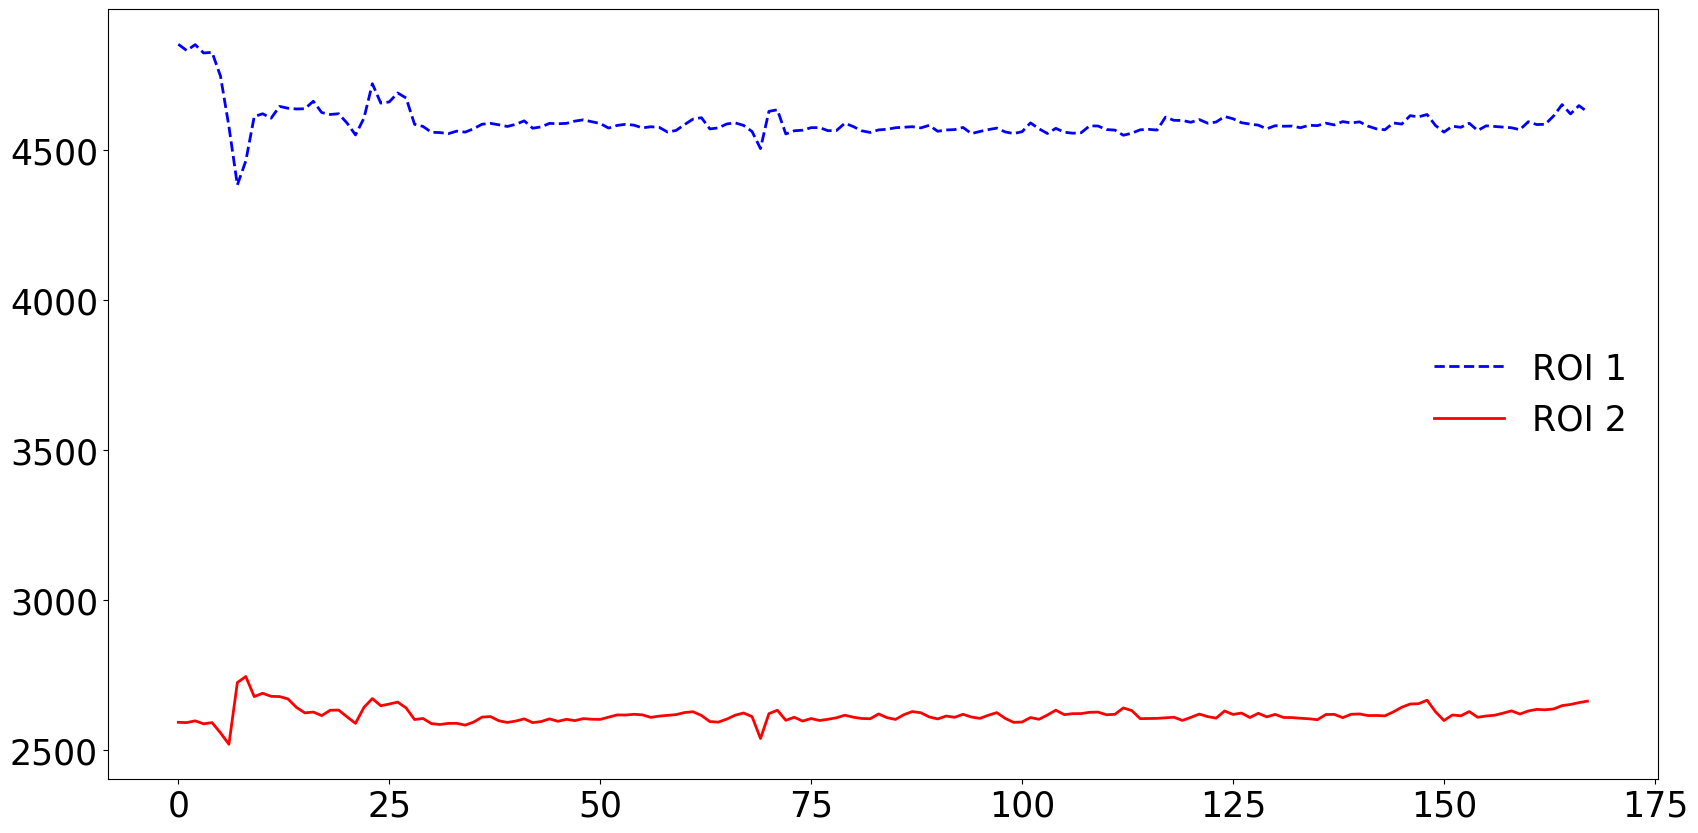

In [47]:
fig = plt.figure(figsize=(20,10))
plt.plot(time_series[:,0],lw=2,ls='--',color='blue',label='ROI 1')
plt.plot(time_series[:,1],lw=2,ls='-',color='red', label='ROI 2')

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),fontsize=25);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=25);
ax.legend(prop={'size':25}, # size of the legend patches inside and the font size
              fontsize='xx-large', # markersize=6 # to increase legend size
              frameon=False);

### The nifti masker here extracted the average ROI signal, but we may want to standartise the average time courses, furthermore we may want to apply a temporal filter and regress out certain confounds. These things can be achieved with the NiftiMasker

In [48]:
masker_clean = NiftiMapsMasker(maps_img=atlas_filename,
                               standarize='zscore',
                              detrend=True,
                              high_pass=0.008,
                               t_r=2, verbose = 1)
time_series_clean = masker_clean.fit_transform(func_image)
print(time_series_clean.shape)



[NiftiMapsMasker.wrapped] loading regions from /content/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[NiftiMapsMasker.transform_single_imgs] Loading data from Nifti1Image('/content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
(168, 39)


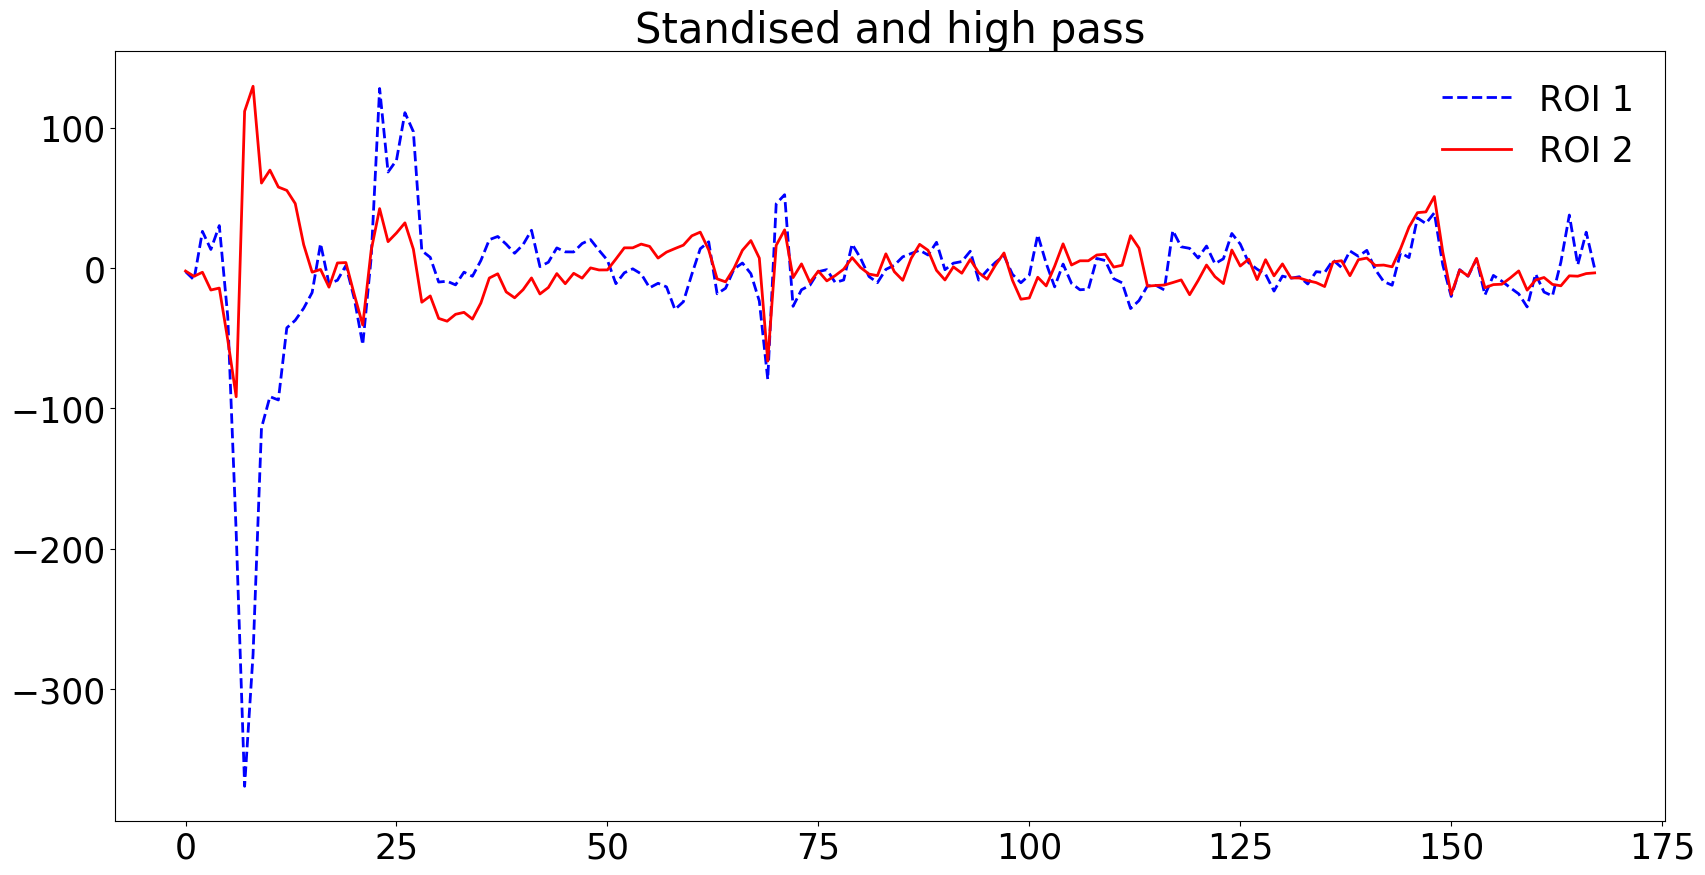

In [49]:
fig = plt.figure(figsize=(20,10))
plt.plot(time_series_clean[:,0],lw=2,ls='--',color='blue',label='ROI 1')
plt.plot(time_series_clean[:,1],lw=2,ls='-',color='red', label='ROI 2')

ax = plt.gca()
ax.set_title('Standised and high pass', fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=25);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=25);
ax.legend(prop={'size':25}, # size of the legend patches inside and the font size
              fontsize='xx-large', # markersize=6 # to increase legend size
              frameon=False);

### We use Connecitivy Measure module
## it returns a N x K x K array representing N -subjects - here 1; K x K connectivity; K is number of regions

In [50]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series_clean])[0]
print(correlation_matrix.shape)
#correlation_matrix = correlation_matrix[0,:,:]
#print(correlation_matrix.shape)

(39, 39)


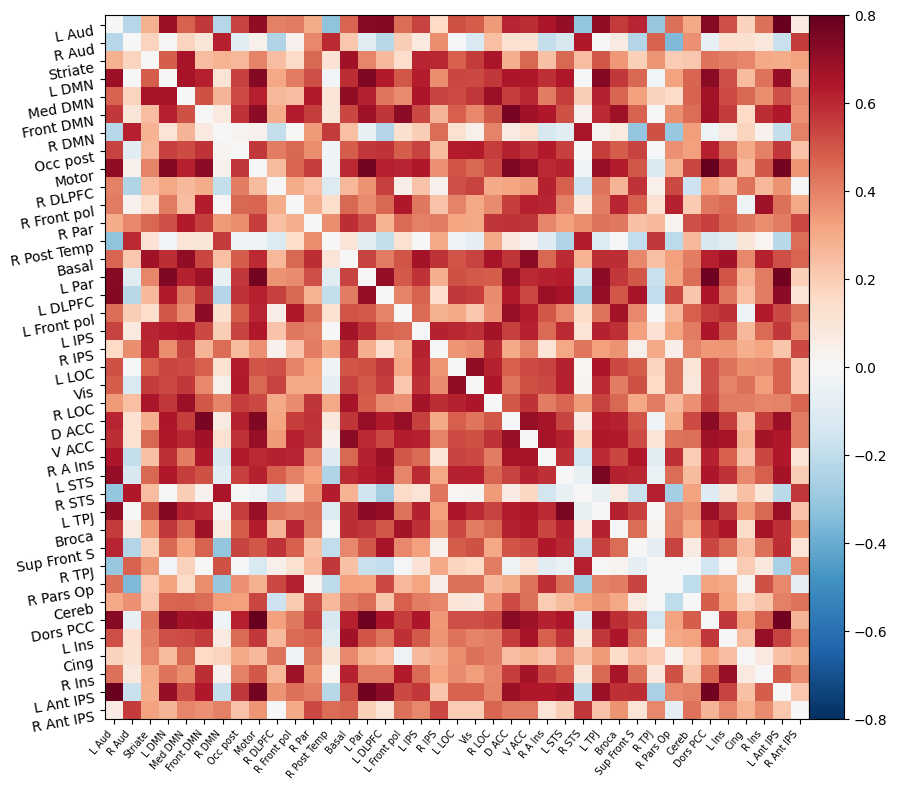

In [51]:
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plt.figure(figsize=(10,8))
ax = plt.gca()

# Plot correlation matrix - note: matrix is ordered for block-like representation
display= plotting.plot_matrix(correlation_matrix, labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10);


#### <span style='color:green'> **Note** </span>
<span style='color:green'> given the 2D array you can also compute the correlations manually just using numpy
however, note that the Connectivity measure uses not a maximum likelihood estimation of the covariance that most people are familiar with but a Ledoit-Wolf estimator that basically shrinks all correlations towards 0 see [here](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance);
Below we show how to compute correlations manually both with numpy and scipy since this may be more flexible

In [52]:
# @title Digression how to compute the correlation matrix manually
# manual_corr = np.corrcoef(time_series_clean.T);
# np.fill_diagonal(manual_corr, 0);
# fig=plt.figure(figsize=(10,8));
# ax = plt.gca();
# pos = ax.imshow(manual_corr, cmap='coolwarm',vmin=-0.8, vmax=0.8);
# fig.colorbar(pos, ax=ax);


#print(correlation_matrix[0:5,0:5])
#print(manual_corr[0:5,0:5])
#print(np.corrcoef(manual_corr[:,0],correlation_matrix[:,0]))
#plt.scatter(manual_corr[:,0],correlation_matrix[:,0] );


## Here we compute distance matrix this is often the inverse of a similarity matrix. High similarity means low distance (commonly used for RSA)


# distance_mat = 1 - np.corrcoef(time_series_clean.T)

# fig=plt.figure(figsize=(10,8));
# ax = plt.gca();
# pos = ax.imshow(distance_mat, cmap='coolwarm',vmin=-0.8, vmax=0.8);
# fig.colorbar(pos, ax=ax);



### Here we use the scipy spatial distance which has not only correlation distance measure but also other options e.g., Eucledian

# from scipy.spatial.distance import pdist
# from scipy.spatial.distance import pdist, squareform

# dist_corr_man = squareform(pdist(time_series_clean.T, metric='correlation'))
# print(dist_corr_man.shape)
# fig=plt.figure(figsize=(10,8));
# ax = plt.gca();
# pos = ax.imshow(dist_corr_man, cmap='coolwarm',vmin=-0.8, vmax=0.8);
# fig.colorbar(pos, ax=ax);

# Regress Confounds before computing connectivity
#### We have quite a lot of regions begin correlated with each other
#### However we did not regress out motion confounds here we examine how removing the confounds affects the connectivity matrix

In [53]:
time_series_clean_confounds = masker_clean.fit_transform(func_image, confounds=confounds_32) # note we specify confounds argument

[NiftiMapsMasker.wrapped] loading regions from /content/msdl_atlas/MSDL_rois/msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from Nifti1Image('/content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals


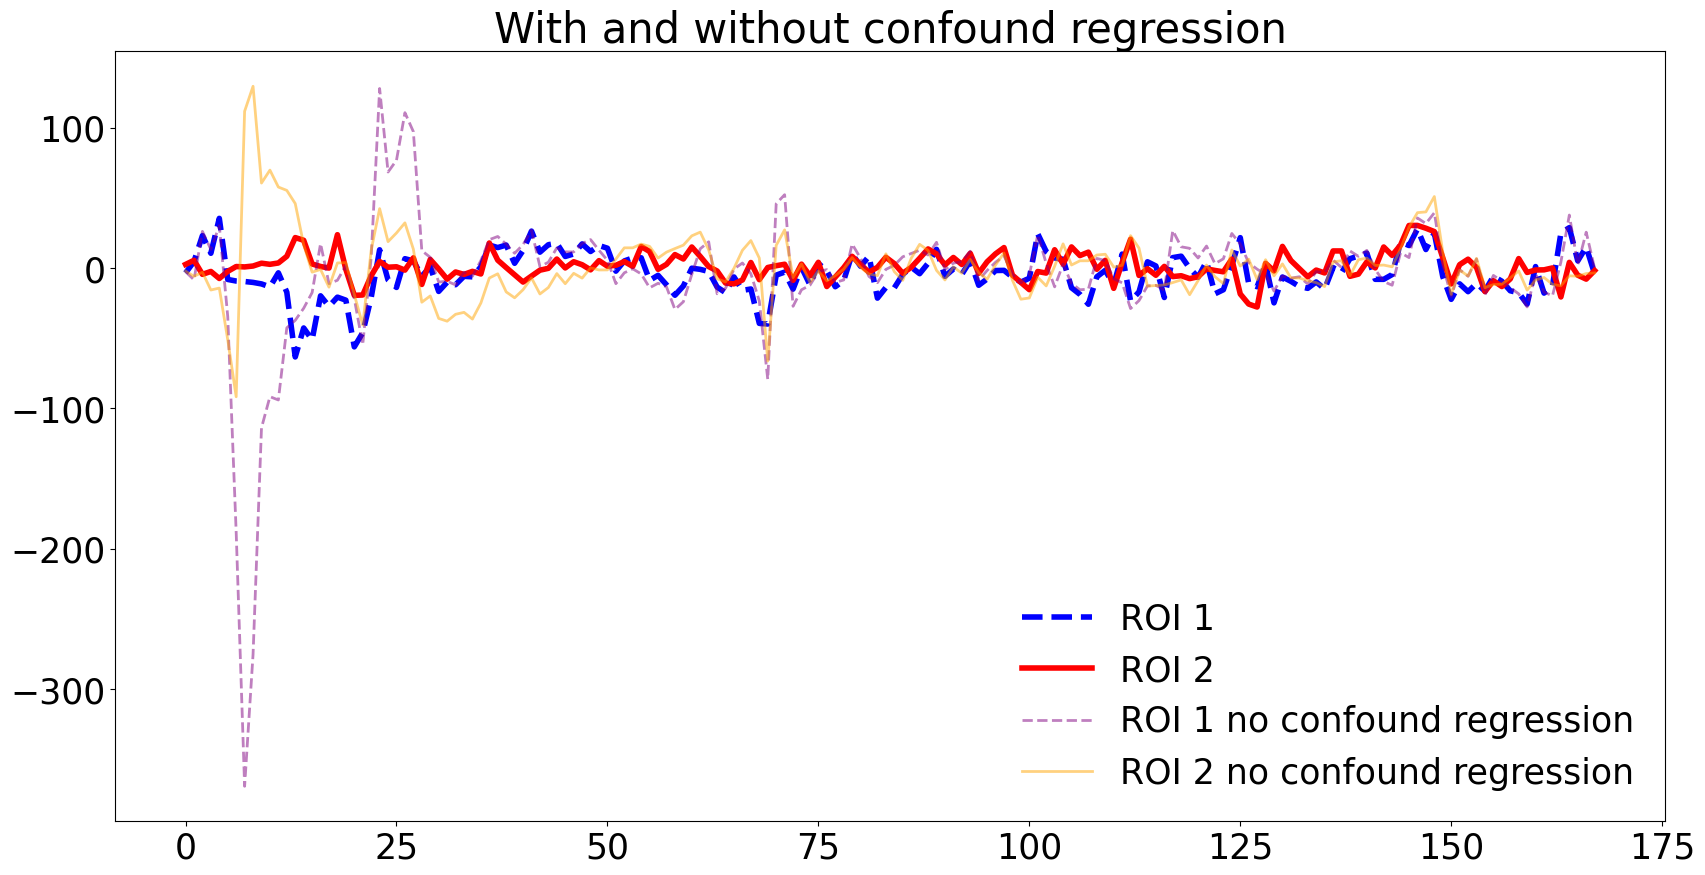

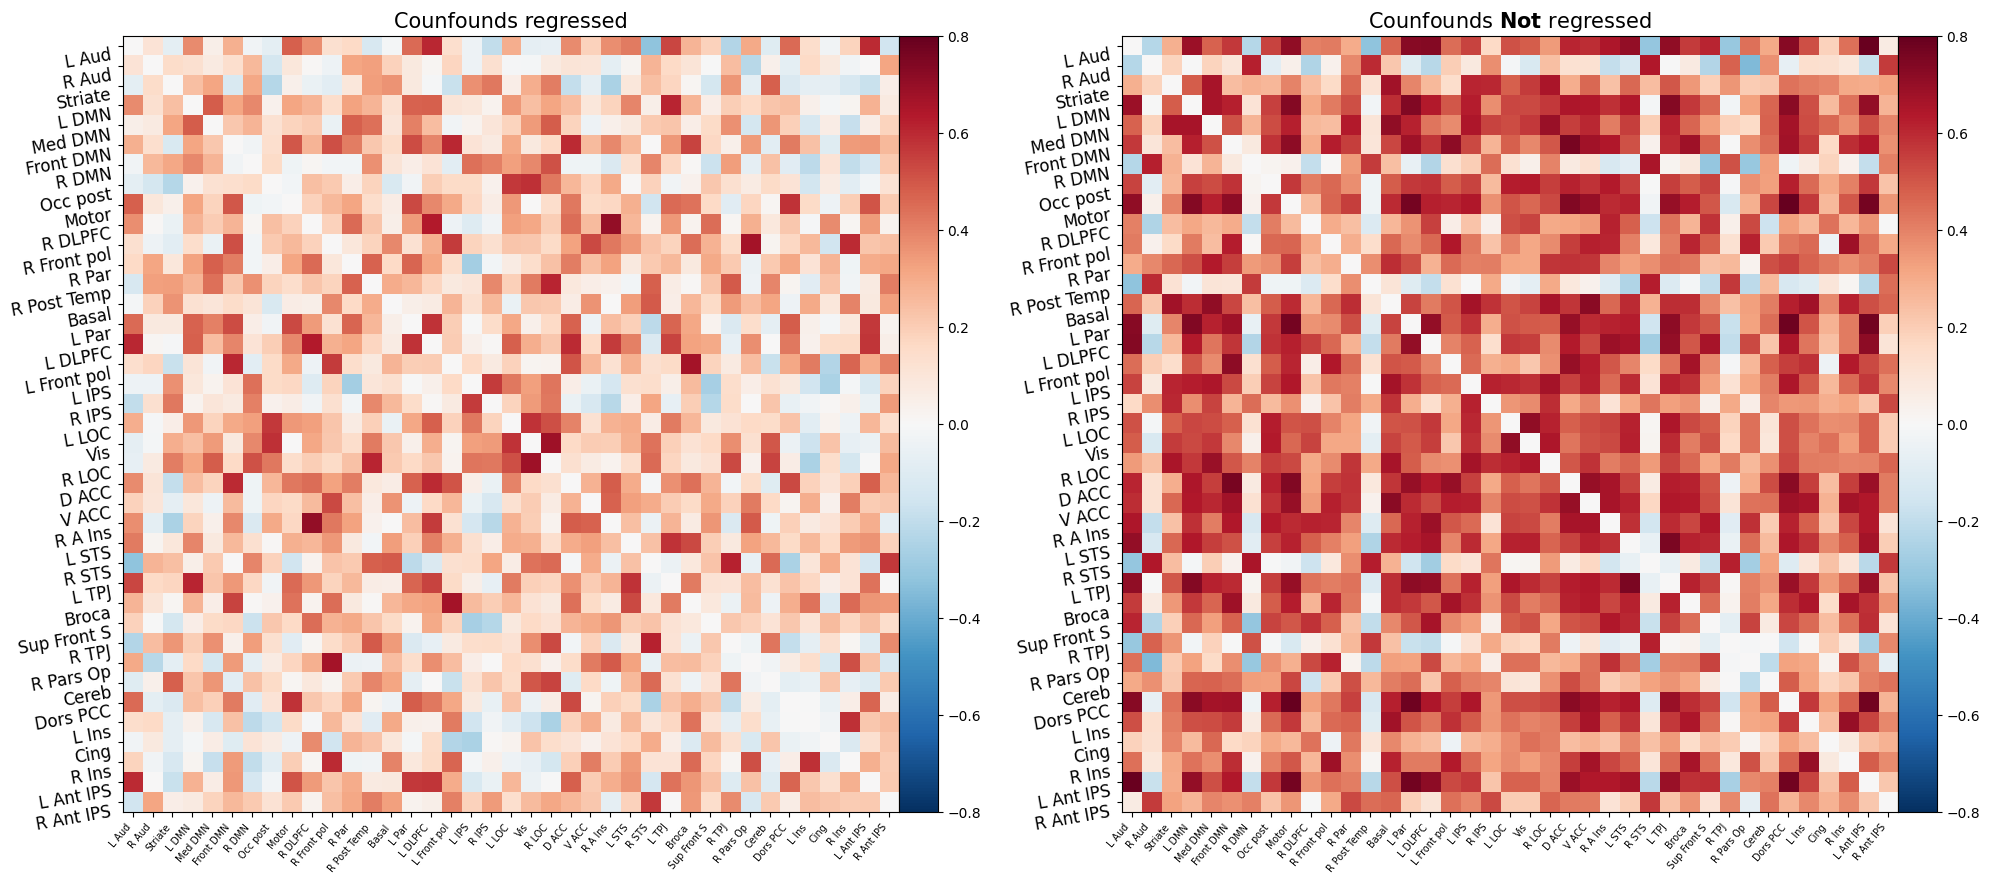

In [54]:
fig = plt.figure(figsize=(20,10))
plt.plot(time_series_clean_confounds[:,0],lw=4,ls='--',color='blue',label='ROI 1',zorder=1)
plt.plot(time_series_clean_confounds[:,1],lw=4,ls='-',color='red', label='ROI 2',zorder=2)

plt.plot(time_series_clean[:,0],lw=2,ls='--',color='purple',label='ROI 1 no confound regression',alpha=0.5)
plt.plot(time_series_clean[:,1],lw=2,ls='-',color='orange', label='ROI 2 no confound regression', alpha=0.5)

ax = plt.gca()
ax.set_title('With and without confound regression', fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=25);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=25);
ax.legend(prop={'size':25}, # size of the legend patches inside and the font size
              fontsize='xx-large', # markersize=6 # to increase legend size
              frameon=False);


# alternatively development_dataset.confounds can be directly passed to confounds
correlation_matrix_confounds = correlation_measure.fit_transform([time_series_clean_confounds])[0]


np.fill_diagonal(correlation_matrix_confounds, 0)



fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))


# Plot correlation matrix - note: matrix is ordered for block-like representation
display= plotting.plot_matrix(correlation_matrix_confounds, labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax1);
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=12);
ax1.set_title('Counfounds regressed',fontsize=15)

display= plotting.plot_matrix(correlation_matrix, labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax2);
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=12);
ax2.set_title("Counfounds " + r"$\bf{" +'Not'+"}$" + ' regressed',fontsize=15)



plt.tight_layout(w_pad=2)

### What if we also regress out global signal



[NiftiMapsMasker.wrapped] loading regions from /content/msdl_atlas/MSDL_rois/msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from Nifti1Image('/content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals


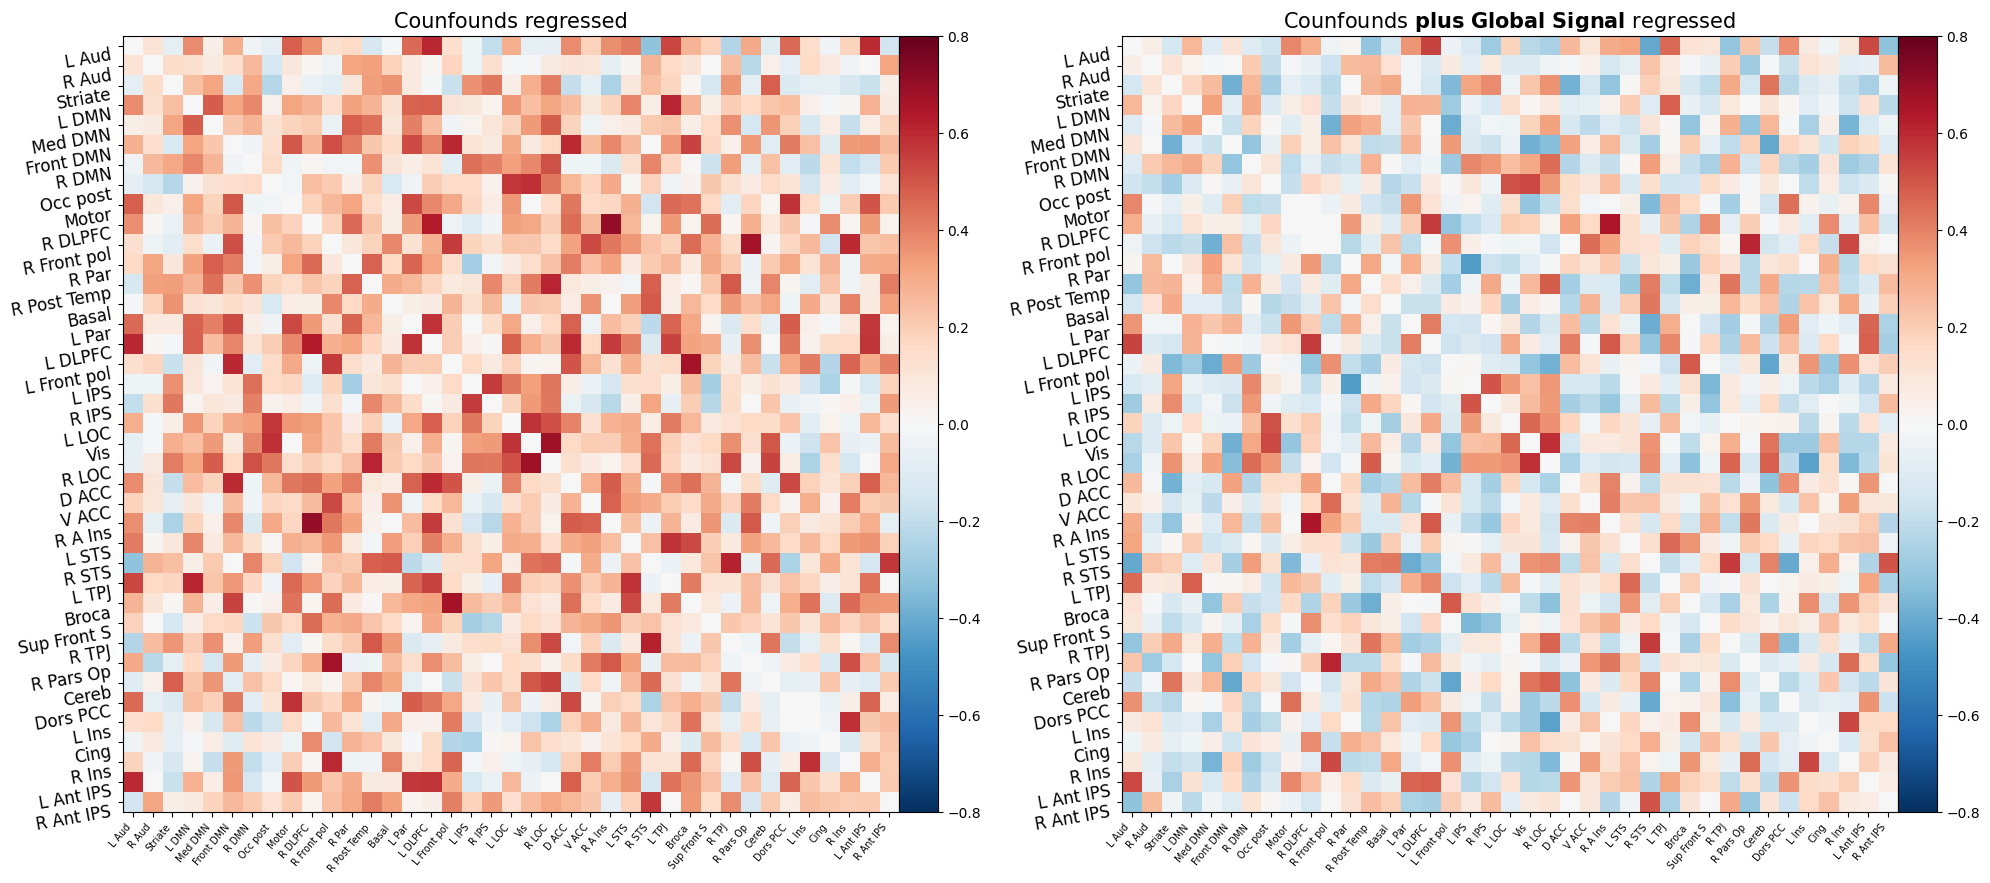

In [55]:
confounds_32_g = confounds_32.copy()
confounds_32_g['Global'] = pd.Series(global_signal)

time_series_clean_confounds_g = masker_clean.fit_transform(func_image, confounds=confounds_32_g)


# alternatively development_dataset.confounds can be directly passed to confounds
correlation_matrix_confounds_global = correlation_measure.fit_transform([time_series_clean_confounds_g])[0]


np.fill_diagonal(correlation_matrix_confounds_global, 0)



fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))


# Plot correlation matrix - note: matrix is ordered for block-like representation
display= plotting.plot_matrix(correlation_matrix_confounds, labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax1);
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=12);
ax1.set_title('Counfounds regressed',fontsize=15)

display= plotting.plot_matrix(correlation_matrix_confounds_global, labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax2);
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=12);
ax2.set_title("Counfounds " + r"$\bf{" +'plus\ Global\ Signal'+"}$" + ' regressed',fontsize=15)



plt.tight_layout(w_pad=2)

### Global signal regression introduces quite a bit of negative connectivities and is still a debated pre-processing option in the field [see here](10.1016/j.neuroimage.2016.11.052). Lets plot the functional connectivity matrix on a brain

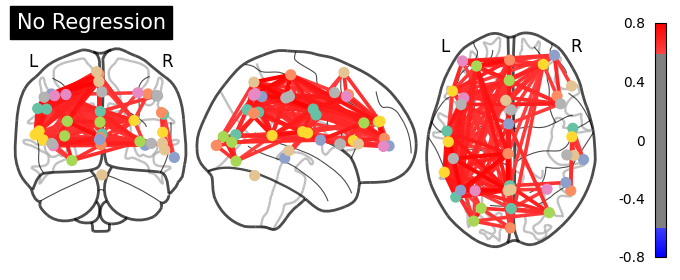

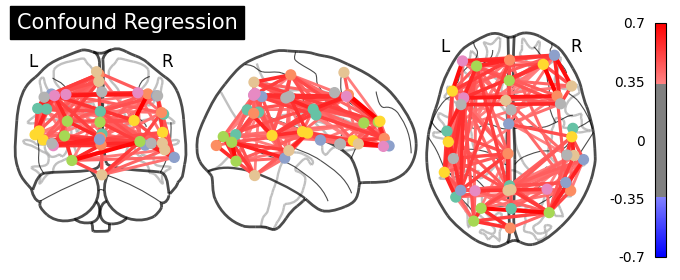

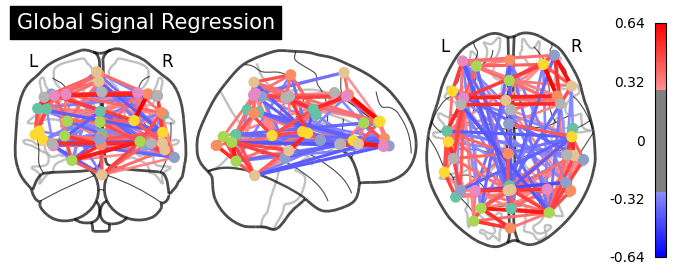

In [56]:
from nilearn import plotting

coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(
    correlation_matrix, coords, edge_threshold="80%", colorbar=True, title='No Regression'
)

plotting.show()

plotting.plot_connectome(
    correlation_matrix_confounds, coords, edge_threshold="80%", colorbar=True, title='Confound Regression'
)

plotting.show()


plotting.plot_connectome(
    correlation_matrix_confounds_global, coords, edge_threshold="80%", colorbar=True, title='Global Signal Regression'
)

plotting.show()

In [57]:
view = plotting.view_connectome(
    correlation_matrix_confounds, coords, edge_threshold="80%"
)
# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

Output hidden; open in https://colab.research.google.com to view.

<br><br><br><br><br>

# Lets compute the ROIxROI over multiple subjects

In [58]:
development_dataset_many = datasets.fetch_development_fmri(n_subjects=Nsub,data_dir=save_dir)
confounds_development = make_motion_covariates(development_dataset_many.confounds)


msdl_coords = atlas.region_coords
n_regions = len(msdl_coords)
print(
    f"MSDL has {n_regions} ROIs, "
    f"part of the following networks:\n{atlas.networks}."
)

MSDL has 39 ROIs, part of the following networks:
['Aud', 'Aud', 'Striate', 'DMN', 'DMN', 'DMN', 'DMN', 'Occ post', 'Motor', 'R V Att', 'R V Att', 'R V Att', 'R V Att', 'Basal', 'L V Att', 'L V Att', 'L V Att', 'D Att', 'D Att', 'Vis Sec', 'Vis Sec', 'Vis Sec', 'Salience', 'Salience', 'Salience', 'Temporal', 'Temporal', 'Language', 'Language', 'Language', 'Language', 'Language', 'Cereb', 'Dors PCC', 'Cing-Ins', 'Cing-Ins', 'Cing-Ins', 'Ant IPS', 'Ant IPS'].


In [59]:
masker_clean = NiftiMapsMasker(maps_img=atlas_filename,
                               standarize='zscore',
                              detrend=True,
                              high_pass=0.008,
                               t_r=2, verbose = 0).fit()
children = [] # we initialize empty lists and then append the extracted time-series
pooled_subjects = []
groups = []  # child or adult
Age_list = []
for func_file, confound_file, phenotypic in zip(
    development_dataset_many.func,
    confounds_development,
    development_dataset_many.phenotypic,
):
    time_series = masker_clean.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    Age_list.append(phenotypic['Age'])
    if phenotypic["Child_Adult"] == "child":
        children.append(time_series)
    groups.append(phenotypic["Child_Adult"])

print(f"Data has {len(children)} children.")

Data has 31 children.


In [60]:
# @title We can use MultiNiftiMapsMasker to extract timeseries from multiple subjects without a for loop
# from nilearn.maskers import MultiNiftiMapsMasker
# multi_masker = MultiNiftiMapsMasker(maps_img=resampled_MSDL_image,
#                                standarize='zscore',
#                               detrend=True,
#                               high_pass=0.008,
#                                t_r=2, verbose = 0)

# mult_time_series = multi_masker.fit_transform(development_dataset_many.func,
#                                               confounds=development_dataset_many.confounds)
# print(len(mult_time_series))
# print(mult_time_series[0].shape)

# connectome_measure2 = ConnectivityMeasure(kind="correlation")
# correlation_matrices2 = connectome_measure2.fit_transform(mult_time_series)

In [61]:
correlation_measure = ConnectivityMeasure(kind="correlation")
CORR_MAT = correlation_measure.fit_transform(pooled_subjects)
print('Corr mat',CORR_MAT.shape)

from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix
low_tril = sym_matrix_to_vec(CORR_MAT,discard_diagonal=True)
print('Shape of Lower triangular matrix',low_tril.shape)
Age = np.array(Age_list)
Age_exp = np.expand_dims(Age,1)
print('Age shape',Age_exp.shape)

Corr mat (40, 39, 39)
Shape of Lower triangular matrix (40, 741)
Age shape (40, 1)


# Now we have for each subject their ROIxROI connectivity stored in the 40 x 741 array (39*38)/2 - We ignore the diagonal as this is self-connections.
# The mass univariate approach fits a GLM model to each edge (cell in the ROIxROI array) independently. We then can examine which edges are effected by our experimental manipulation or relate to some trait of the participants.
# Here we correlate each edge with Age to try and examine which edges show different connectivity across age.

![Mass_Univariate](https://b01.eventmemory.org/APPCA/Mass_Univariate_Connectivity.png)

In [62]:
import statsmodels.api as sma

beta_values = np.zeros((1,low_tril.shape[1])) # here we initialise a 1 by 741 for the beta values, change this if more complicated design
p_values = np.zeros((1,low_tril.shape[1])) # here we initialise a 1 by 741 for the p values, change this if more complicated design
t_values = np.zeros((1,low_tril.shape[1]))

X = sma.add_constant(Age_exp)

for i in range(low_tril.shape[1]):

    y = low_tril[:,i]
    temp_model = sma.OLS(y,X).fit()
    beta_values[0,i] = temp_model.params[1]# first coef is the constant
    p_values[0,i] = temp_model.pvalues[1]
    t_values[0,i] = temp_model.tvalues[1]



## We can apply an FDR correction across all the ROI connections

In [63]:
from statsmodels.stats.multitest import fdrcorrection
H_vec, p_corr = fdrcorrection(np.squeeze(p_values), alpha = 0.05,method='indep',is_sorted=False)
print('ROIs passing correction:', np.where(H_vec==1)[0])

ROIs passing correction: [ 13  17  25  45  54  65  78 120 133 135 138 160 178 207 208 209 217 229
 231 232 244 253 254 257 258 263 264 267 269 275 276 277 289 299 300 301
 325 326 357 368 369 378 379 390 393 395 396 414 416 428 429 430 441 453
 460 474 477 482 483 496 503 504 514 524 528 546 583 584 585 586 587 612
 613 616 621 638 641 652 653 654 656 662 698]


In [64]:
p_value_sq = np.squeeze(p_values)
t_value_sq = np.squeeze(t_values)
T_P_array = np.vstack((t_value_sq[H_vec==1], p_value_sq[H_vec==1])).T
temp_df = pd.DataFrame( T_P_array,columns=['t_val','p_val'])
temp_df.index = np.where(H_vec==1)[0]
temp_df

t_val         p_val
13   3.177198  2.951075e-03
17   2.988463  4.893323e-03
25  -3.668530  7.447307e-04
45   3.426044  1.484216e-03
54   2.995249  4.806350e-03
..        ...           ...
653  3.901846  3.774281e-04
654  5.920199  7.325015e-07
656  3.659616  7.640940e-04
662  3.020143  4.499605e-03
698  3.763558  5.656545e-04

[83 rows x 2 columns]

### Alternatively we can apply FWE correction with permutation

In [65]:
from nilearn.mass_univariate import permuted_ols

perm_result = permuted_ols(target_vars = low_tril,tested_vars=X[:,1],n_perm=500,output_type="dict")
perm_result.keys() # this gives the original t values,
# the negative log 10 corrected p values and the max t values
threshold = -np.log10(0.05)
print('ROIs passing correction',np.where(perm_result['logp_max_t'] > threshold)[1])
idx = np.squeeze(perm_result['logp_max_t']) > threshold
t_value_sq = np.squeeze(perm_result['t'])
t_value_sq[idx]


ROIs passing correction [244 300 325 369 585 586 654]


array([4.76998485, 4.57116274, 4.69786673, 4.93960703, 4.49868725,
       5.32270877, 5.92019916])

In [66]:
diagonal_nan = np.empty((39))
diagonal_nan[:] = np.nan
diagonal_nan.shape

p_value_mat = vec_to_sym_matrix(p_value_sq,diagonal=diagonal_nan) # we removed the diagonal initially so now we have to provide it back so we end up with a 39x39 array
hypothesis_mat = vec_to_sym_matrix(H_vec,diagonal=diagonal_nan)
beta_value_mat = vec_to_sym_matrix(np.squeeze(beta_values), diagonal=diagonal_nan)
print('\nHypothesis mat shape:\n', hypothesis_mat.shape)
print('\nBeta Values shape: \n',beta_value_mat.shape)


Hypothesis mat shape:
 (39, 39)

Beta Values shape: 
 (39, 39)


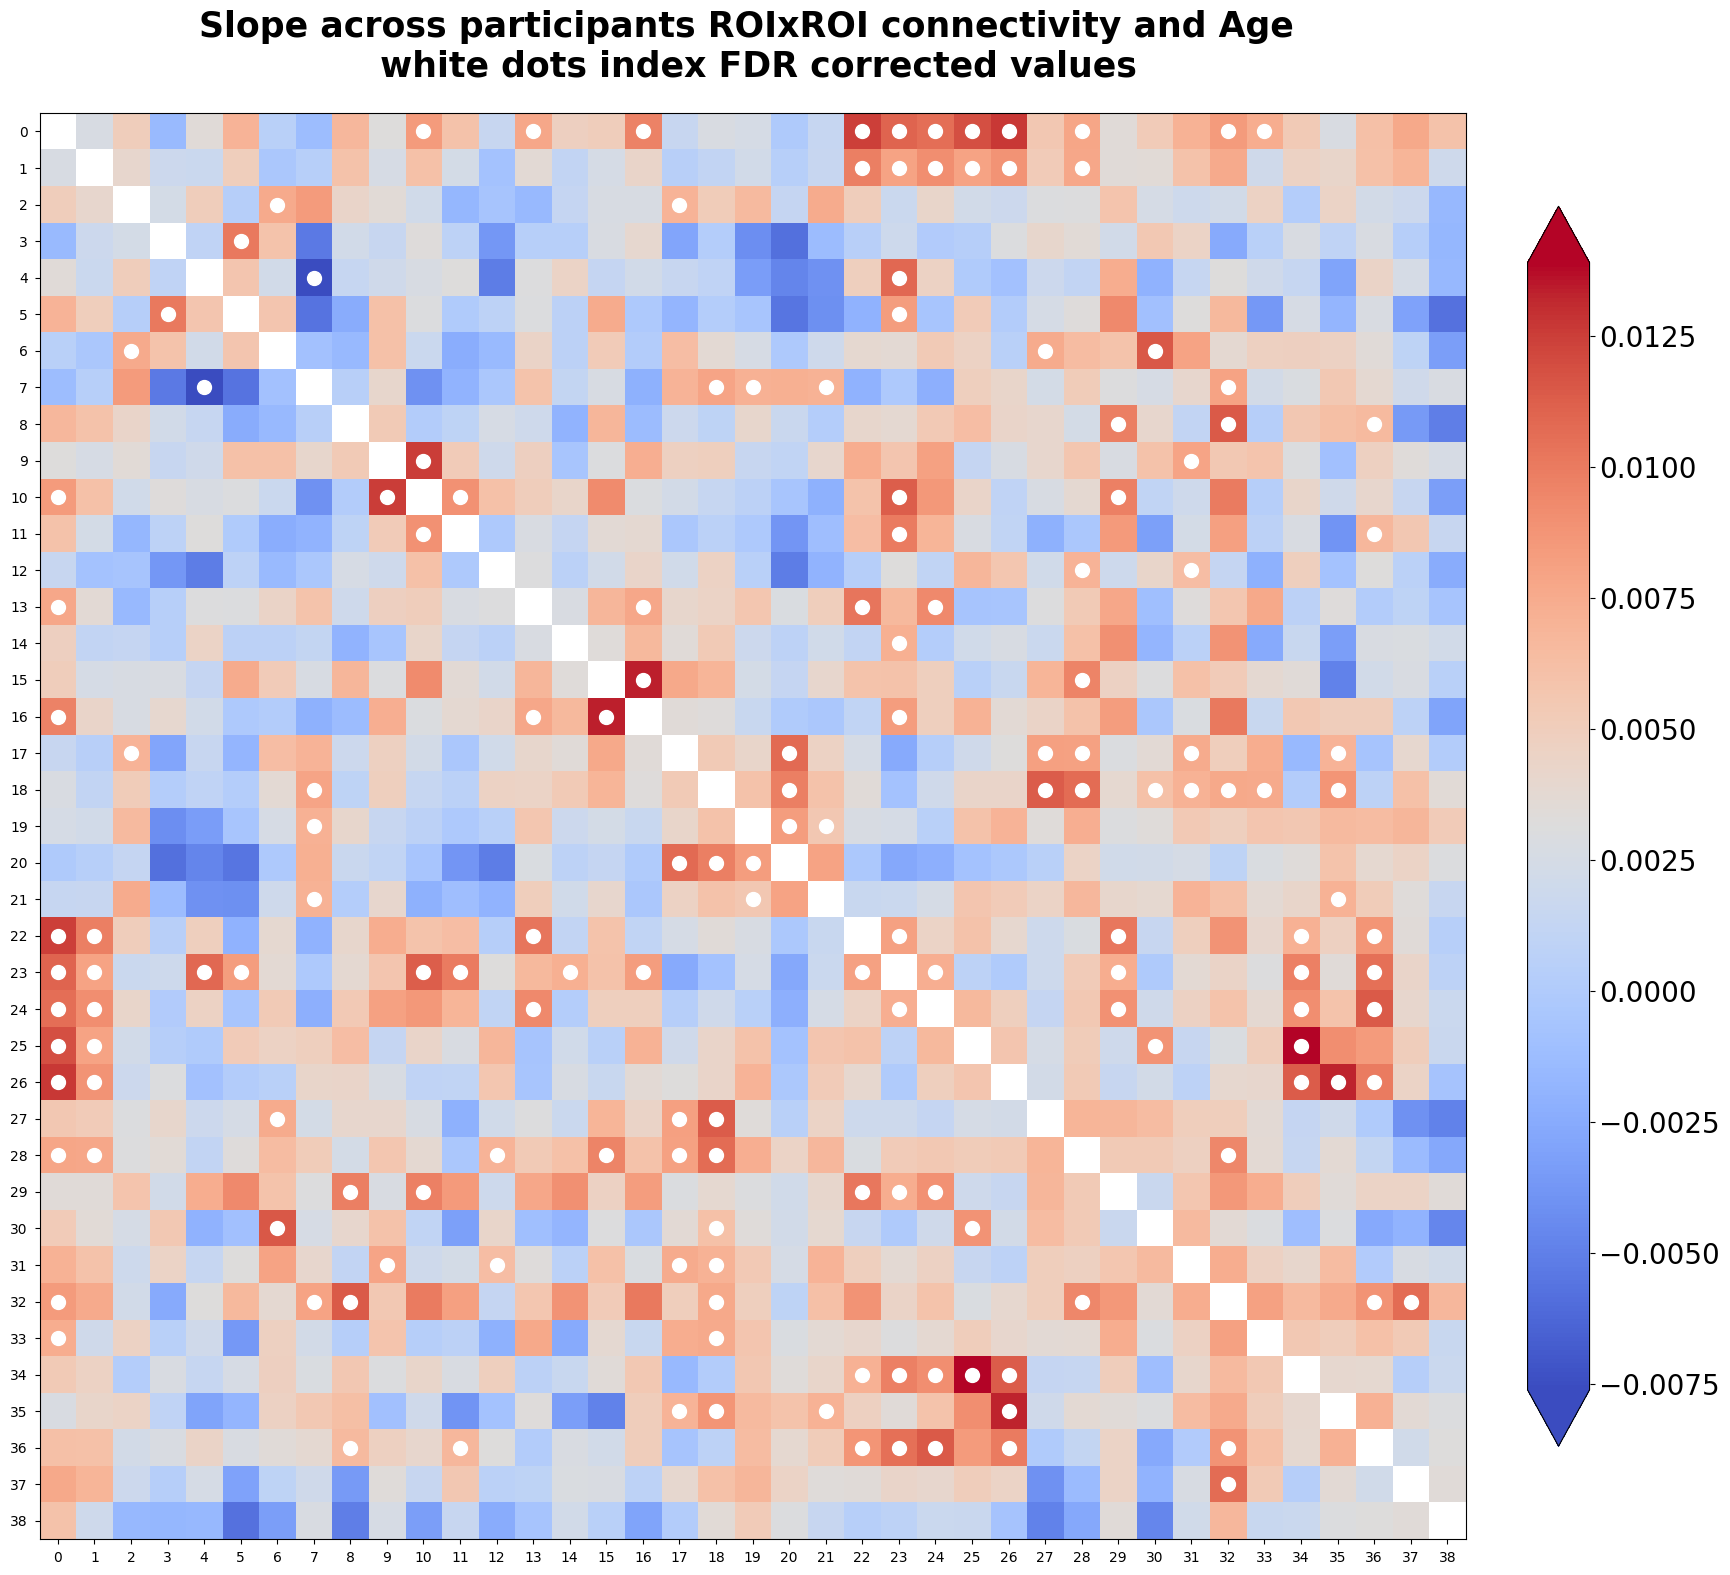

In [67]:
plt.figure(figsize=(20,20))
ax = plt.gca()

C = ax.imshow(beta_value_mat,cmap='coolwarm')

# highlight things above 0.2
logical_mat = hypothesis_mat==1
# ax.spy(logical_mat,alpha=.2,cmap='viridis')
ax.spy(logical_mat,marker='.', markersize=20,color='white')

ax.set_title('Slope across participants ROIxROI connectivity and Age \n white dots index FDR corrected values',
             weight='bold', fontsize=25, y=1.02)

# COLORBAR

cbar = fig.colorbar(C,fraction= 0.040,pad=0.04,ax=ax,ticks=None,extend='both')# ,extend='both'
cbar.ax.tick_params(labelsize=20)

ticks = np.arange(0,len(beta_value_mat))
ax.set_xticks(ticks);
ax.xaxis.tick_bottom()
ax.set_yticks(ticks);

ax.tick_params(axis='both', which='major', pad=5) # original gap was 25

In [68]:
plt.close('all')

# To get at more direct connectivity we can use partial correlation rather than pearson correlation. To achieve that we can use the inverse Sparce Covariance Matrix in order to get the direct connections. Note this is similiar to computing the partial correlation it can allows us to view the association between two regions after account it for other regions influence.

(168, 39)


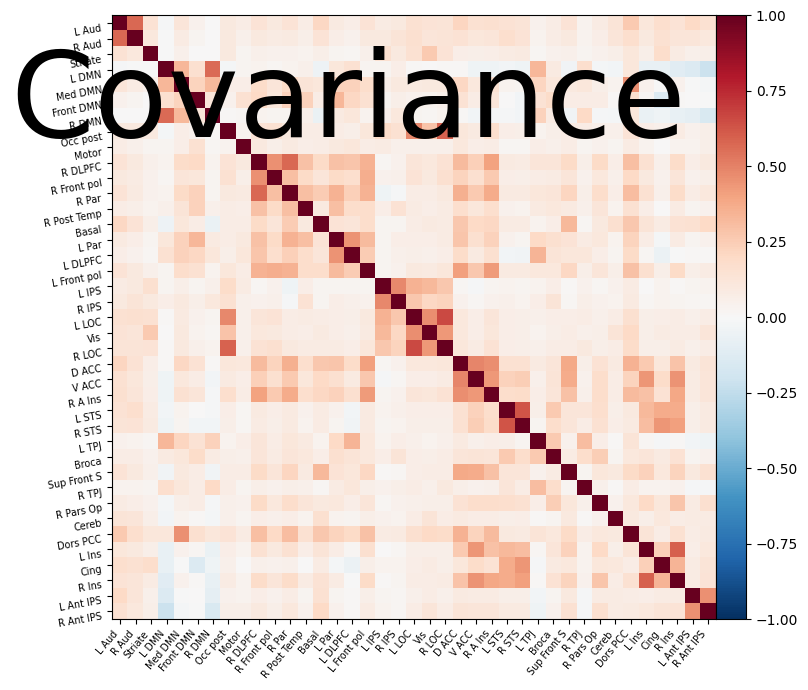

In [69]:
data_adult = datasets.fetch_development_fmri(n_subjects=1,age_group='adult',data_dir=save_dir)

masker_adult = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    memory="nilearn_cache",
    verbose=0,
    detrend=True,
    high_pass=0.008,
    t_r=2,
)

adult_confounds = make_motion_covariates(data_adult.confounds[0])

time_series_adult = masker_adult.fit_transform(data_adult.func[0],
                                               confounds=adult_confounds) # note we specify confounds argument



print(time_series_adult.shape)
from sklearn.covariance import GraphicalLassoCV
estimator = GraphicalLassoCV()
estimator.fit(time_series_adult)

plotting.plot_matrix(estimator.covariance_,
                    labels=labels,
                    figure=(9,7),
                    vmax=1,
                    vmin=-1,
                    title='Covariance')



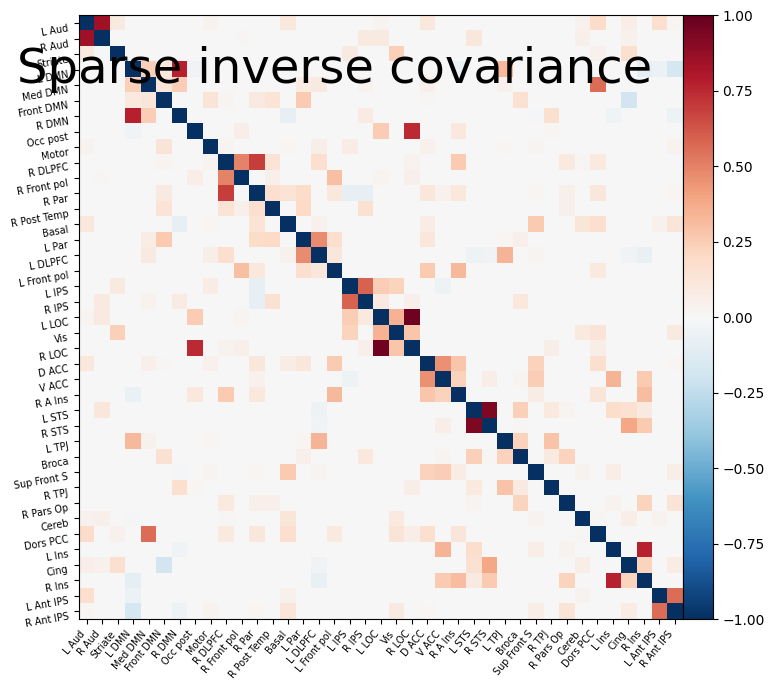

In [70]:
fig,ax1 = plt.subplots(1,1,figsize=(9,7))

# the negative precision matrix is the partial correlations
display = plotting.plot_matrix(
    -estimator.precision_,
    labels=labels,
    vmax=1,
    vmin=-1,
    title="Sparse inverse covariance",
    axes=ax1
)

### For detailed example of using the Sparce inverse covariance see [here](https://nilearn.github.io/dev/connectivity/connectome_extraction.html)

# There are different Connectivity measures, full correlation, partial correlation - connectivity between to regions conditioned on connectivity of other regions

# Apart from running mass univariate GLM on the connectivity edges we can also run multivariate methods which take as regressors the functional edges and try to predict some characteristic of the participants. For instance we might use the whole connectivity matrix to examine whether it containts information that can help us classify children vs adults.

![Multivariate_image](https://b01.eventmemory.org/APPCA/Multivariate.png)

# We run a classification of participants age to see which correlation method better. For different classification examples check sklearn documentation [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
## Note for imbalanced classes read this [paper](https://doi.org/10.1016/j.neuroimage.2023.120253)

In [71]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

kinds = ["correlation", "partial correlation"]
_, classes = np.unique(groups, return_inverse=True) # gets indices of unique items
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects) # pooled_subjects is the list of time_series we extracted above

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        if kind == 'correlation':
            print('train - {} | test - {}'.format(np.bincount(classes[train]), np.bincount(classes[test])))

        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC(class_weight='balanced').fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test])
        )
        # store the accuracy for this cross-validation fold
        scores[kind].append(balanced_accuracy_score(classes[test], predictions))
#print(classes[train])
#print(classes[test])

train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]
train - [ 8 27] | test - [1 4]


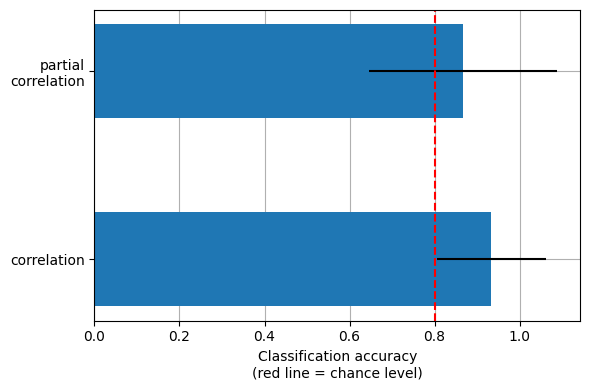

In [72]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * 0.1 + 0.1
plt.barh(positions, mean_scores, align="center", height=0.05, xerr=scores_std)
yticks = [k.replace(" ", "\n") for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(0.8, color="red", linestyle="--")
plt.xlabel("Classification accuracy\n(red line = chance level)")
plt.tight_layout()

<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>

# Here we show how to run ICA on an individual subject's data
# Nilearn does not have a specific module for ICA and just uses a the sklearn ICA module that can be applied to any numpy array data see [paper](https://www.frontiersin.org/articles/10.3389/fninf.2014.00014/full#h7) that introduces nilearn

# If you are classifying manually components as noise check out this [paper](https://doi.org/10.1016/j.neuroimage.2016.12.036)

# Note for invidual subject data you can run ICA AROMA easily from fMRIprep. Other common approaches are GIFT matlab toolbox and Melodic FSL toolbox.

In [73]:
adult_dataset = datasets.fetch_development_fmri(n_subjects=1, data_dir=save_dir)

func_filename=adult_dataset.func[0]

Whole_brain_masker = NiftiMasker(smoothing_fwhm=8,memory='nilearn_cache',
                                memory_level=1,
                                mask_strategy="epi",
                                standardize='zscore',detrend=True) # Note here we are extracting the signal from the whole brain
# Under the hood NiftiMasker is computing a EPI mask - determining which voxels have brain signal,
# zscoring and detrending the signal in each voxel across time - a basic clean up strategy
# and running a smoothing kernel on the whole brain images

adult_whole_brain = Whole_brain_masker.fit_transform(func_filename)
print('We transformed the data to be not 4D nibabel image but a 2D numpy array with shape', adult_whole_brain.shape)
print('We have %d time points and %d voxels for 1 subject' %(adult_whole_brain.shape))
print('Nilearn and sklearn data to be n_samples x n_features')

We transformed the data to be not 4D nibabel image but a 2D numpy array with shape (168, 24256)
We have 168 time points and 24256 voxels for 1 subject
Nilearn and sklearn data to be n_samples x n_features


## We have the data as a 2D numpy array. Data is treated as n_samples x n_features

In [74]:
from sklearn.decomposition import PCA, FastICA

n_components=20 # choosing the number of components is critical, rule of thumb is between 20-60 more often possibly between 20-30;
# FSL Melodic has an build-in option to estimate the number of components to keep, however this can over-estimate the number of components that are needed
# Choosing the number of components affects the functional 'nodes' or the networks extracted from ICA, as more components can potentially fragment a network into sub-networks
# read here for more information - https://neurostars.org/t/automatic-estimation-of-number-if-ica-components-in-nilearn-canica/287/6

pca = PCA(n_components=n_components, random_state=42)
ica = FastICA(n_components=n_components, random_state=42)
components_masked_pca = pca.fit_transform(adult_whole_brain.T).T

components_masked_ica = ica.fit_transform(adult_whole_brain.T).T

# in sklearn and nilearn the shape is always n_samples x n_feautres
# to do spatial ICA, the directon considered as random is that of voxels and not the timepoints
# effectively we find statistically independent spatial maps and their associated time-courses
print(components_masked_ica.shape)

(20, 24256)


In [75]:
# Normalize estimated components, for thresholding to make sense
# components_masked_pca -= components_masked_pca.mean(axis=0)
# components_masked_pca /= components_masked_pca.std(axis=0)

from scipy import stats
components_masked_pca_zscored_spatially = stats.zscore(components_masked_pca,axis=1)

components_masked_ica -= components_masked_ica.mean(axis=0)
components_masked_ica /= components_masked_ica.std(axis=0)
components_masked_ica[np.abs(components_masked_ica) < 0.8] = 0 # here thresholding is arbitrary, previously a strategy is to threshold the components to show the voxels that are Z > 2; However, this is not necessarily the most effective strategy
# since the spatial maps should be non-Gaussian by definition of being derived from ICA decomposition; FSL uses a Mixture of Gaussians to perform the thresholding see here https://www.fmrib.ox.ac.uk/datasets/techrep/tr02cb1/tr02cb1/node1.html

ica_image = Whole_brain_masker.inverse_transform(components_masked_ica)
pca_image = Whole_brain_masker.inverse_transform(components_masked_pca_zscored_spatially)

PCA components Time course shape (20, 168)
ICA components Time course shape (20, 168)


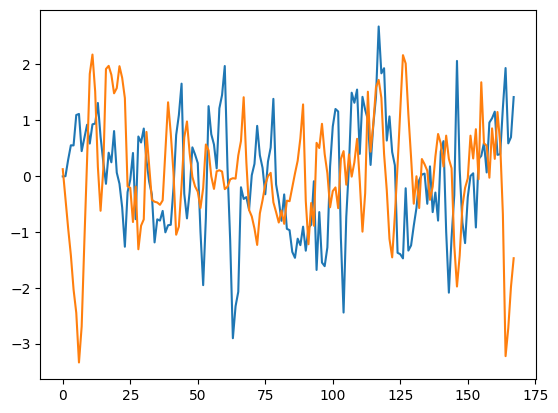

In [76]:
print('PCA components Time course shape', pca.components_.shape)
print('ICA components Time course shape', ica.components_.shape) # Under the hood ICA actualy first runs PCA to select the 20 components and then runs ICA

plt.plot(zscore(pca.components_[1,:]))
plt.plot(zscore(ica.components_[1,:])) # If this was a block design rather than a resting or movie state we could hope to observe that some of the components show a similar time-course to the task

20 components explain 59% of the variance


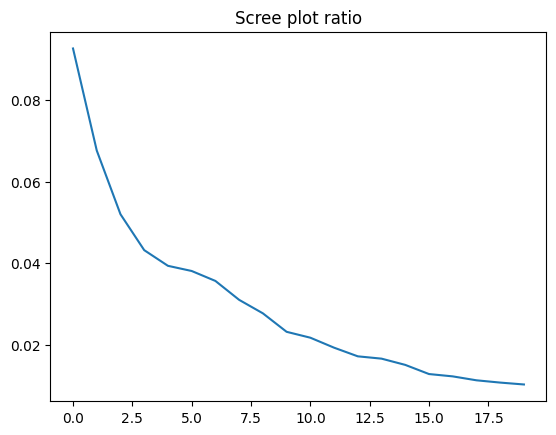

In [77]:
plt.plot(pca.explained_variance_ratio_)
ax =plt.gca()
ax.set_title('Scree plot ratio')

print('%d components explain %d%% of the variance' %(n_components ,np.sum(pca.explained_variance_ratio_) * 100) )


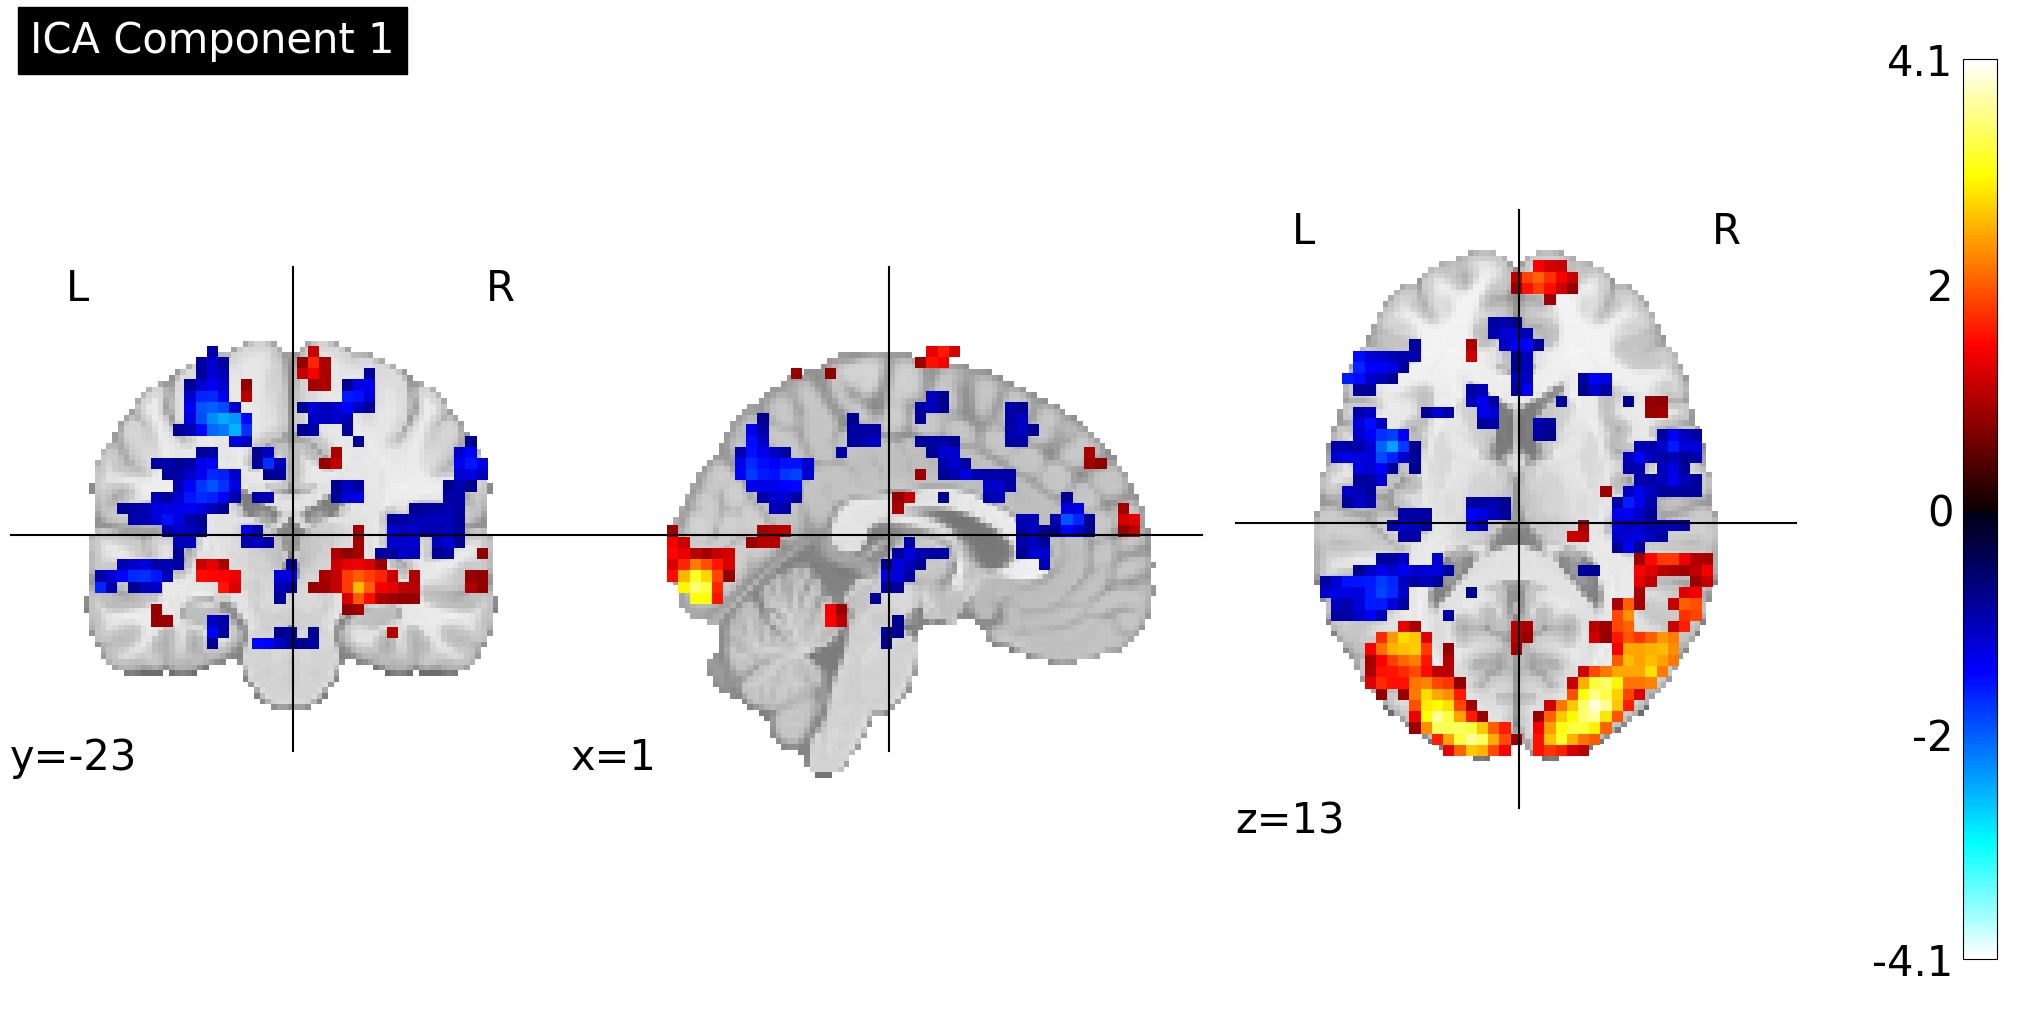

In [78]:
fig = plt.figure(figsize=(20,10))

display = plotting.plot_stat_map(image.index_img(ica_image, 1),
                        title='Component 1', figure = fig , threshold=0, cut_coords=[1,-23,13],black_bg=0)

display.title('ICA Component 1',size=30)
display.annotate(size=30)

cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=30)

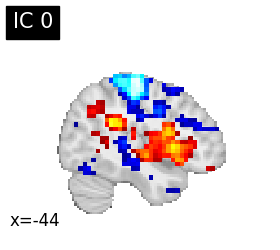

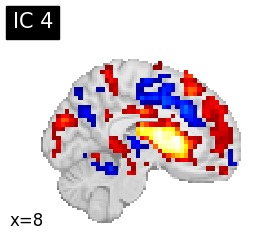

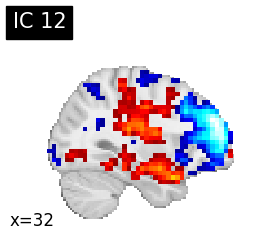

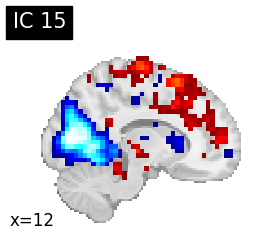

In [79]:
from nilearn.image import iter_img
# show all components
# for i, cur_img in enumerate(iter_img(ica_image)):
#     plot_stat_map(
#         cur_img,
#         display_mode="y",
#         title=f"IC {int(i)}",
#         cut_coords=1,
#         colorbar=False,
#     )

for i in [0,4,12,15]:
    plotting.plot_stat_map(
        image.index_img(ica_image,i),
        display_mode="x",
        title=f"IC {int(i)}",
        cut_coords=1,
        colorbar=False,
    )

# Now lets use nltools which provides a better interface for ICA
# we need to load the data as BrainData object see [here](https://dartbrains.org/content/ICA.html)

interactive(children=(BoundedIntText(value=0, description='Component', max=19), BoundedFloatText(value=2.0, de…

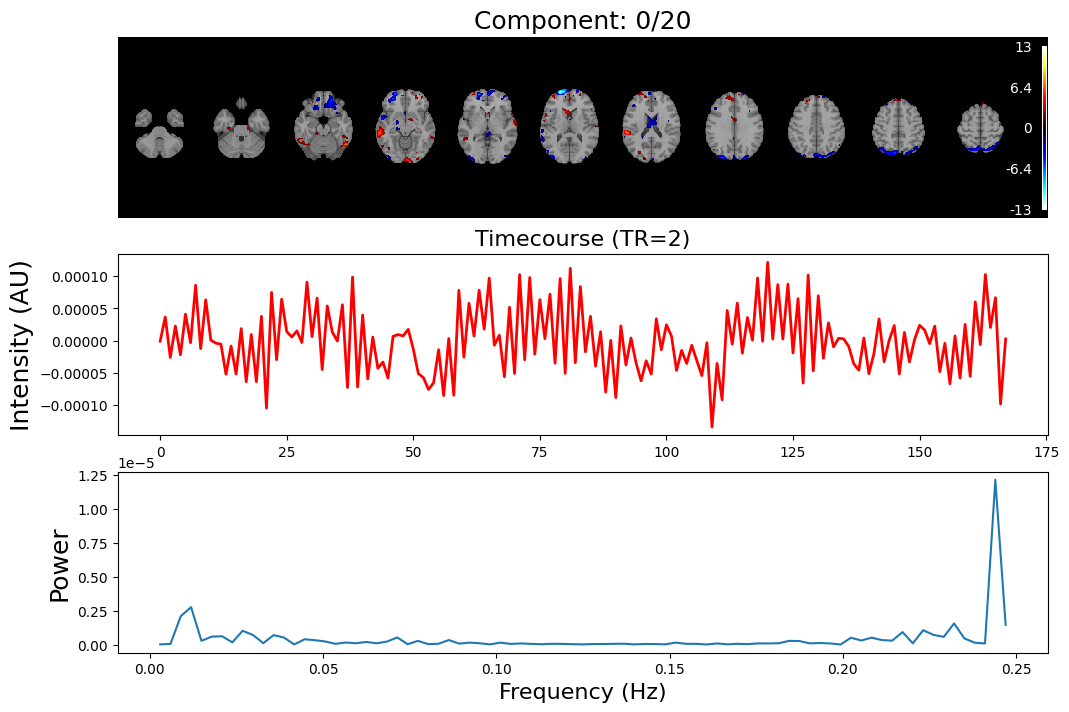

In [80]:
from nltools.data import Brain_Data
from nltools.plotting import component_viewer

data_B = Brain_Data(func_filename)
data_B
data_B = data_B.filter(sampling_freq=1/2, high_pass=1/128)
data_B = data_B.smooth(8)
tr = 2
output = data_B.decompose(algorithm='ica', n_components=20, axis='images') # this again uses sklearn FastICA algorithm
component_viewer(output, tr=2)

# A problem with single-subject ICA is that the components are not necessarily consistent across participants.
# One can concatenate the time-series and run ICA on the whole group of subjects this approach concatenation approach is common and used in both GIFT and FSL
# If the time-course is similar across subjects e.g., they performed the same task one can use tensorial ICA as used in FSL


---


# To keep the components consistent across subjects one can also perform Canonical ICA described in detail [here](https://doi.org/10.1016/j.neuroimage.2010.02.010) This analysis takes a 3 step approach of:


#1. First reducing the dimension of each participants fMRI data;
#2. Performing Canonical Correlation analysis, a correlation measure between two sets of variables, that ensures consistency across participants and finds a lower dimensional space common to the group of participants
#3. Performing ICA on the common group space to extract group ICA components

In [81]:
from nilearn import datasets

rest_dataset = datasets.fetch_development_fmri(n_subjects=30, data_dir=save_dir)
func_filenames = rest_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print(f"First functional nifti image (4D) is at: {rest_dataset.func[0]}")

First functional nifti image (4D) is at: /content/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


# Lets use the function we wrote to clean up the confounds from fMRIprep

see [here](https://neurostars.org/t/confounds-from-fmriprep-which-one-would-you-use-for-glm/326/47) for discussion on which confounds to use, see also [here](https://neurostars.org/t/denoising-strategy-with-fmriprep-confounds/17563), Opinions are far and wide on this but often you will need to regress more than the 6 motion parameters and may consider including signal from white matter, CSF and possibly global signal. Including their derivatives and squares is an additional common strategy. Note ideally you will regress all confounds in a single [model](https://doi.org/10.1002/hbm.24528)

In [82]:
confounds_list = make_motion_covariates(rest_dataset.confounds)
print('Length of list',len(confounds_list))

Length of list 30


In [83]:
from nilearn.decomposition import CanICA

NumComp = 20
canica = CanICA(
    n_components=NumComp,
    memory="nilearn_cache",
    memory_level=2,
    verbose=10,
    mask_strategy="whole-brain-template",
    random_state=0,
    standardize="zscore_sample",
)
canica.fit(func_filenames)

# Retrieve the independent components in brain space. Directly
# accessible through attribute `components_img_`.
canica_components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
canica_components_img.to_filename("canica_resting_state.nii.gz")

[MultiNiftiMasker.fit] Loading data from [/content/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar127_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /content/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   10.0s


__________________________________________________________fastica - 8.4s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=924231285)
__________________________________________________________fastica - 9.6s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=1478610112)
__________________________________________________________fastica - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0

[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   37.8s


__________________________________________________________fastica - 8.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=1537364731)
__________________________________________________________fastica - 9.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=192771779)
__________________________________________________________fastica - 9.5s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0

[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.1min


__________________________________________________________fastica - 7.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=1819583497)
__________________________________________________________fastica - 9.6s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004071, ...,  0.000497],
       ...,
       [ 0.005856, ..., -0.004765]]), whiten='arbitrary-variance', fun='cube', random_state=530702035)
_________________________________________________________fastica - 10.2s, 0.2min


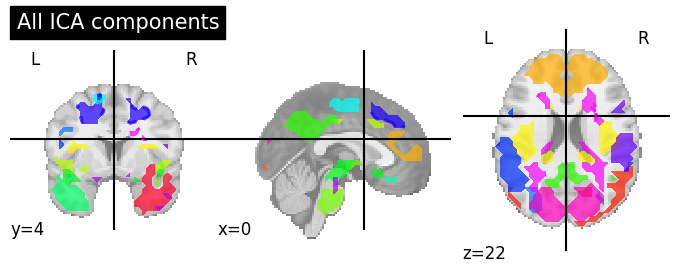

In [84]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(canica_components_img, title="All ICA components")

In [85]:
canICA_masker = MultiNiftiMapsMasker(canica_components_img,smoothing_fwhm=8,standardize='zscore',detrend=True,
                               t_r=2,low_pass=0.1)

mult_time_series = canICA_masker.fit_transform(rest_dataset.func,
                                              confounds=confounds_list)
print('Number of people',len(mult_time_series))
print('Time series per component',mult_time_series[0].shape)

connectome_measure2 = ConnectivityMeasure(kind="correlation")
correlation_matrices2 = connectome_measure2.fit_transform(mult_time_series)
print('Shape of correlation matrix',correlation_matrices2.shape)

Number of people 30
Time series per component (168, 20)
Shape of correlation matrix (30, 20, 20)


(168, 20)


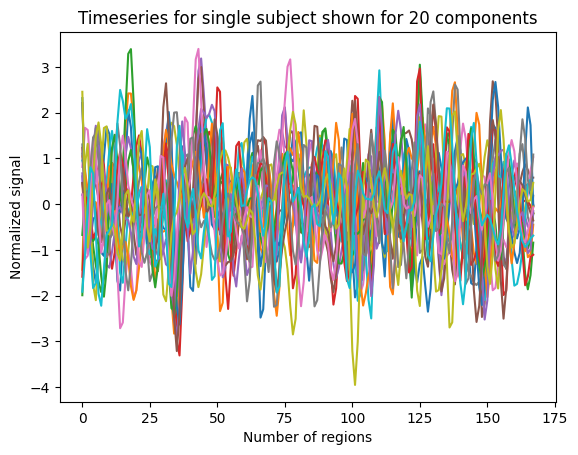

In [86]:
# Visualizing extracted timeseries signals. We import matplotlib.pyplot
import matplotlib.pyplot as plt


# We show them for a single subject
timeseries = mult_time_series[0]
print(timeseries.shape) # (number of scans/time points, number of brain regions/parcellations)
plt.plot(timeseries)
plt.title('Timeseries for single subject shown for 20 components')
plt.xlabel('Number of regions')
plt.ylabel('Normalized signal')
plt.show()

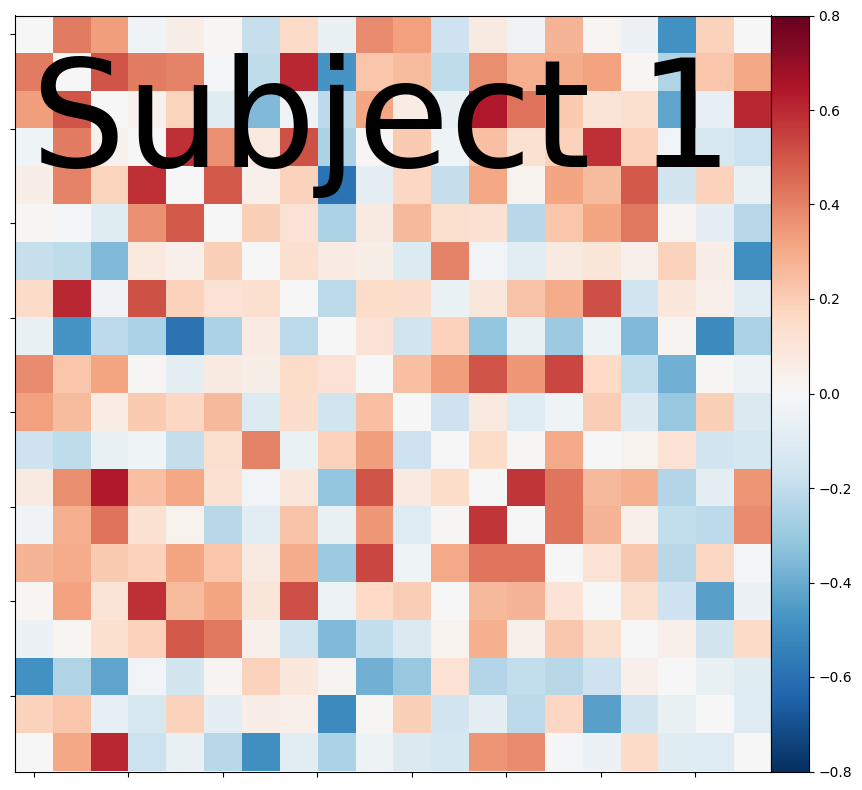

In [87]:
# Mask the main diagonal for visualization:
sub_1_corr_mat = np.squeeze(correlation_matrices2[0,:,:])

np.fill_diagonal(sub_1_corr_mat, 0)

plt.figure(figsize=(10,8))
ax = plt.gca()

# Plot correlation matrix - note: matrix is ordered for block-like representation
display= plotting.plot_matrix(sub_1_corr_mat,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax,title='Subject 1');
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10);

In [88]:
# @title One can iterate over all components and plot them
# from nilearn.image import iter_img
# from nilearn.plotting import plot_stat_map, show

# for i, cur_img in enumerate(iter_img(canica_components_img)):
#     plot_stat_map(
#         cur_img,
#         display_mode="z",
#         title=f"IC {int(i)}",
#         cut_coords=1,
#         colorbar=False,
#     )

# Alternatively one can run Dictonary learning see here

In [89]:
# @title Dictonary learning
# from nilearn.decomposition import DictLearning

# dict_learning = DictLearning(
#     n_components=20,
#     memory="nilearn_cache",
#     memory_level=2,
#     verbose=1,
#     random_state=0,
#     n_epochs=1,
#     mask_strategy="whole-brain-template",
#     standardize="zscore_sample",
# )

# print("[Example] Fitting dictionary learning model")
# dict_learning.fit(func_filenames)
# print("[Example] Saving results")
# # Grab extracted components umasked back to Nifti image.
# # Note: For older versions, less than 0.4.1. components_img_
# # is not implemented. See Note section above for details.
# dictlearning_components_img = dict_learning.components_img_
# dictlearning_components_img.to_filename(
#     "dictionary_learning_resting_state.nii.gz"
# )

# plot_prob_atlas(
#     dictlearning_components_img, title="All DictLearning components"
# )

# scores = dict_learning.score(func_filenames, per_component=True)

# print('Explained Variance per component:\n',scores)

In [90]:
# @title You can additionally extract Regions from the canICA components and extract the time-series of the individual regions
# from nilearn.regions import RegionExtractor

# extractor = RegionExtractor(
#     canica_components_img,
#     threshold=2,
#     thresholding_strategy="ratio_n_voxels",
#     extractor="local_regions",
#     standardize="zscore_sample",
#     min_region_size=1350,
# )
# # Just call fit() to process for regions extraction
# extractor.fit()
# # Extracted regions are stored in regions_img_
# regions_extracted_img = extractor.regions_img_
# # Each region index is stored in index_
# regions_index = extractor.index_
# # Total number of regions extracted
# n_regions_extracted = regions_extracted_img.shape[-1]

# # Visualization of region extraction results
# title = (
#     "%d regions are extracted from %d components."
#     "\nEach separate color of region indicates extracted region"
#     % (n_regions_extracted, NumComp)
# )
# plotting.plot_prob_atlas(
#     regions_extracted_img, view_type="filled_contours", title=title
# )




# from nilearn.connectome import ConnectivityMeasure

# correlations = []
# # Initializing ConnectivityMeasure object with kind='correlation'
# connectome_measure = ConnectivityMeasure(kind="correlation")
# confounds = make_motion_covariates(rest_dataset.confounds)
# for filename, confound in zip(func_filenames, confounds):
#     # call transform from RegionExtractor object to extract timeseries signals
#     timeseries_each_subject = extractor.transform(filename, confounds=confound)
#     # call fit_transform from ConnectivityMeasure object
#     correlation = connectome_measure.fit_transform([timeseries_each_subject])
#     # saving each subject correlation to correlations
#     correlations.append(correlation)

# # Mean of all correlations
# import numpy as np

# mean_correlations = np.mean(correlations, axis=0).reshape(
#     n_regions_extracted, n_regions_extracted
# )

# Another common way to perform Group ICA is FSL's dual regression approach see [here](https://fsl.fmrib.ox.ac.uk/fslcourse/2019_Beijing/lectures/ICA_and_resting_state/ICA_and_Dual_Regression.pdf) and lecture [here](https://www.youtube.com/watch?v=Xs_c3-neuec&ab_channel=FSLCourse)

# ICA or clustering approaches can be useful for identifying networks and testing hypothesis at the network level, however, one might be particularly interested how one specific regions' connectivity with the rest of the brain differs across participants. This functional connectivity analysis is often termed seed to whole brain analysis. We will below show you how to extract signal from a single seed and compute seed to whole brain connectivity

# Exercises

1. Add Spike Regressors to the clean-up pipeline
2. Use a separate atlas to examine differences in the functional connectome
3. Run Analyses with more people


# You can check out Rik's lecture on effective connectivity and Dynamic causal modelling. We also include a matlab tutorial on DCM.



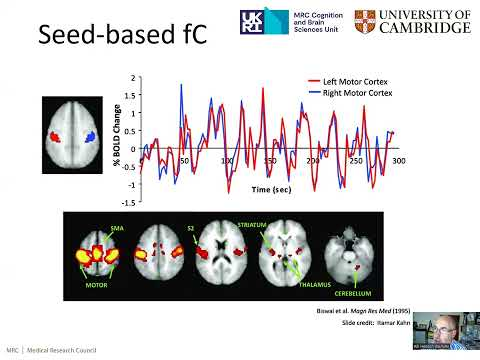

In [91]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start=int(timedelta(hours=0, minutes=15, seconds=10).total_seconds())

YouTubeVideo('1VOKsWWLgjk',start=start)

<br><br><br><br><br>